# **Hourly energy demand generation and weather**

This dataset includes two .csv files with hourly data on electricity generation and weather in Spain from 2015 to 2019 (4 years). Specifically:

> 'weather_features.csv': This file contains hourly weather data for five major Spanish cities: Madrid, Barcelona, Valencia, Seville, and Bilbao.

> 'energy_dataset.csv': This file provides hourly information on energy generation in Spain. It includes data (in MW) on the electricity generated by various sources, the total national grid load, and the energy price (€/MWh). Note: Since each energy type's generation is in MW and the data is hourly, each cell represents MWh (Megawatt hours).

The weather data for the five major cities in Spain (marked with a red star on the map below) is likely sufficient for our analysis. Their geographic distribution uniformly covers most of Spain's territory. Additionally, these five cities alone represent about one-third of Spain's total population.

![Get Started](cartina-della-Spagna-fisica.jpg)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

#machine learning
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Warnings Ignore
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# **Exploratory Data Analysis and Data Cleaning**

## Dataset Reading

In [2]:
# df_energy = pd.read_csv('/kaggle/input/energy-consumption-generation-prices-and-weather/energy_dataset.csv')
# df_weather = pd.read_csv('/kaggle/input/energy-consumption-generation-prices-and-weather/weather_features.csv')

df_energy = pd.read_csv('dataset/energy_dataset.csv')
df_weather = pd.read_csv('dataset/weather_features.csv')

In [3]:
# Convert time to datetime object

df_weather['dt_iso'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather.rename(columns={'dt_iso': 'time'}, inplace=True)
df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)

## Weather Dataset

In [4]:
df_weather.head(10)

,time,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
5,2015-01-01 04:00:00+00:00,Valencia,270.292,270.292,270.292,1004,71,2,321,0.0,0.0,0.0,0,800,clear,sky is clear,01n
6,2015-01-01 05:00:00+00:00,Valencia,270.292,270.292,270.292,1004,71,2,321,0.0,0.0,0.0,0,800,clear,sky is clear,01n
7,2015-01-01 06:00:00+00:00,Valencia,270.292,270.292,270.292,1004,71,2,321,0.0,0.0,0.0,0,800,clear,sky is clear,01n
8,2015-01-01 07:00:00+00:00,Valencia,274.601,274.601,274.601,1005,71,1,307,0.0,0.0,0.0,0,800,clear,sky is clear,01d
9,2015-01-01 08:00:00+00:00,Valencia,274.601,274.601,274.601,1005,71,1,307,0.0,0.0,0.0,0,800,clear,sky is clear,01d


In [5]:
# Change from Kelvin to Celsius

df_weather["temp_Celsius"] = df_weather.temp - 273.15
df_weather["temp_min_Celsius"] = df_weather.temp_min - 273.15
df_weather["temp_max_Celsius"] = df_weather.temp_max - 273.15
df_weather.drop(columns = ['temp', 'temp_min', 'temp_max'], inplace = True)

# Reindex the columns

new_column_order = ['city_name', 'time', 'temp_Celsius', 'temp_min_Celsius', 'temp_max_Celsius','pressure', 'humidity', 'wind_speed', 
                    'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h','clouds_all', 'weather_id', 'weather_main', 'weather_description','weather_icon']
df_weather = df_weather.reindex(columns = new_column_order)
df_weather.tail(10)

,city_name,time,temp_Celsius,temp_min_Celsius,temp_max_Celsius,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
178386,Seville,2018-12-31 13:00:00+00:00,16.00,16.0,16.0,1029,59,5,60,0.0,0.0,0.0,0,800,clear,sky is clear,01d
178387,Seville,2018-12-31 14:00:00+00:00,17.00,17.0,17.0,1028,51,5,40,0.0,0.0,0.0,0,800,clear,sky is clear,01d
178388,Seville,2018-12-31 15:00:00+00:00,18.00,18.0,18.0,1028,48,5,50,0.0,0.0,0.0,0,800,clear,sky is clear,01d
178389,Seville,2018-12-31 16:00:00+00:00,18.00,18.0,18.0,1028,42,4,50,0.0,0.0,0.0,0,800,clear,sky is clear,01d
178390,Seville,2018-12-31 17:00:00+00:00,18.23,17.0,19.0,1028,42,4,60,0.0,0.0,0.0,0,800,clear,sky is clear,01d
178391,Seville,2018-12-31 18:00:00+00:00,14.61,14.0,15.0,1028,54,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178392,Seville,2018-12-31 19:00:00+00:00,12.61,12.0,13.0,1029,62,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178393,Seville,2018-12-31 20:00:00+00:00,12.00,12.0,12.0,1028,58,4,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178394,Seville,2018-12-31 21:00:00+00:00,11.00,11.0,11.0,1029,57,4,60,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178395,Seville,2018-12-31 22:00:00+00:00,10.82,9.0,12.0,1029,70,3,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [6]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   city_name            178396 non-null  object             
 1   time                 178396 non-null  datetime64[ns, UTC]
 2   temp_Celsius         178396 non-null  float64            
 3   temp_min_Celsius     178396 non-null  float64            
 4   temp_max_Celsius     178396 non-null  float64            
 5   pressure             178396 non-null  int64              
 6   humidity             178396 non-null  int64              
 7   wind_speed           178396 non-null  int64              
 8   wind_deg             178396 non-null  int64              
 9   rain_1h              178396 non-null  float64            
 10  rain_3h              178396 non-null  float64            
 11  snow_3h              178396 non-null  float64            
 12  cl

In [7]:
df_weather.describe().round(4)

,temp_Celsius,temp_min_Celsius,temp_max_Celsius,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.0000,178396.0000,178396.0000,1.783960e+05,178396.0000,178396.0000,178396.0000,178396.0000,178396.0000,178396.0000,178396.0000,178396.0000
mean,16.4686,15.1804,17.9413,1.069261e+03,68.4235,2.4706,166.5912,0.0755,0.0004,0.0048,25.0733,759.8319
std,8.0262,7.9555,8.6125,5.969632e+03,21.9029,2.0959,116.6119,0.3988,0.0073,0.2226,30.7741,108.7332
min,-10.9100,-10.9100,-10.9100,0.000000e+00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,200.0000
25%,10.5200,9.3336,11.5000,1.013000e+03,53.0000,1.0000,55.0000,0.0000,0.0000,0.0000,0.0000,800.0000
50%,16.0000,15.0000,17.0000,1.018000e+03,72.0000,2.0000,177.0000,0.0000,0.0000,0.0000,20.0000,800.0000
75%,22.0000,20.5801,24.0000,1.022000e+03,87.0000,4.0000,270.0000,0.0000,0.0000,0.0000,40.0000,801.0000
max,42.4500,42.0000,48.0000,1.008371e+06,100.0000,133.0000,360.0000,12.0000,2.3150,21.5000,100.0000,804.0000


We can see that `df_weather` has 178396 rows, but we need to verify the number of rows for each individual city is equivalent. The most significant observation is the presence of **problems** and **outliers**:

- The `pressure` column contains an outlier with a maximum value of 1.008371e+06 hPa (about 100 MPa). This value is clearly incorrect, since at sea level the pressure is 1013.25 hPa.

- The `'wind_speed'` column also has an outlier with a maximum value of 133 m/s. Such extreme wind speeds have not been recorded in Spain.

- The `'3h_rain'` column, which should provide precipitation data for the last 3 hours, should logically have a higher average than the `'1h_rain'` column, which covers the last hour. However, this is not the case, so these columns require further examination.

In [8]:
# Display the mean value for each columns grouped by the city

mean_weather_without_time = df_weather.drop(columns = ['time', 'weather_description', 'weather_main', 'weather_icon'])
mean_weather_by_city = mean_weather_without_time.groupby('city_name').mean()
mean_weather_by_city

,temp_Celsius,temp_min_Celsius,temp_max_Celsius,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
city_name,,,,,,,,,,,,
Barcelona,16.698248,15.444704,17.871987,1284.010486,73.994221,2.786588,187.188043,0.117079,0.000327,0.000000,23.229648,760.917465
Bilbao,13.228489,11.766661,14.886687,1017.567439,79.089455,1.957470,159.883536,0.123493,0.001034,0.023455,43.960697,723.943228
Madrid,14.911071,13.674877,16.005600,1011.838448,59.776932,2.441696,173.293159,0.055083,0.000129,0.000029,22.397028,762.260264
Seville,19.955431,18.034103,22.812431,1018.504711,64.140732,2.483787,151.757179,0.045392,0.000180,0.000000,14.748770,771.409849
Valencia,17.630780,17.072277,18.205025,1015.973794,65.145113,2.692815,160.753820,0.035924,0.000226,0.000154,20.820999,781.228283


### Outliers

An outlier is a data point that differs significantly from other observations in a dataset. It is an unusually high or low value that deviates markedly from the rest of the data. Outliers can occur due to variability in the data, measurement errors, or experimental errors. Identifying and understanding outliers is crucial as they can affect the results of data analysis and statistical modeling.

There are several ways to identify outliers:

### Box Plot:
A box plot (or box-and-whisker plot) is a standardized way of displaying the distribution of data based on a five-number summary: minimum, first quartile (Q1), median, third quartile (Q3), and maximum.

**Components of a Box Plot:**
- **Box:** The central box represents the interquartile range (IQR), which is the distance between the first quartile (Q1) and the third quartile (Q3). It contains the middle 50% of the data.
- **Median Line:** A line inside the box shows the median (the middle value) of the data.
- **Whiskers:** Lines (whiskers) extend from the box to the smallest and largest values within 1.5*IQR from Q1 and Q3, respectively.
- **Outliers:** Data points outside the whiskers are considered outliers and are often shown as individual dots or asterisks.

### Scatter Plot:
A scatter plot is a type of data visualization that displays values for typically two variables for a set of data. The data points are plotted on a Cartesian coordinate system where each point represents an observation in the dataset.

**Components of a Scatter Plot:**
- **X-axis:** Represents the index or one variable of the dataset.
- **Y-axis:** Represents the other variable or the value being examined.
- **Data Points:** Each point represents an observation.

In [9]:
# Functions for the plot of the outlier
def box_and_scatter_plot(df, df_column):
    fig, axs = plt.subplots(1, 2, figsize = (20, 7))

    # Create a box plot in the first subplot
    sns.boxplot(x=df[df_column], ax = axs[0])
    axs[0].set_xlabel('Pressure (hPa)')
    axs[0].set_title('Box Plot of ' + df_column + ' to Identify Outliers')

    # Create a scatter plot in the second subplot
    sns.scatterplot(x = df.index, y = df[df_column], ax=axs[1])
    axs[1].set_xlabel('Index')
    axs[1].set_ylabel(df_column)
    axs[1].set_title('Scatter Plot of ' + df_column + ' to Identify Outliers')

    # Adjust the layout
    plt.tight_layout()

    # Show the plots
    plt.show()

def visualize_outlier(df, city, var, date1 = '2014-12-31 23:00:00+00:00', date2 = '2018-12-31 22:00:00+00:00', date3 = False, date4 = False):
    df_weather_city = df[df['city_name'] == city]
    if date3 == False:
        time_mask = (df_weather_city['time'] > date1) & (df_weather_city['time'] < date2)
    
        plot_mask = df_weather_city[time_mask]
        
        plt.figure(figsize=(15, 7))
        plt.plot(plot_mask['time'], plot_mask[var].values, label = city)
        plt.xlabel('Date')
        plt.ylabel(var)

        plt.show()
    else:
        time_mask1 = (df_weather_city['time'] > date1) & (df_weather_city['time'] < date2)
        time_mask2 = (df_weather_city['time'] > date3) & (df_weather_city['time'] < date4)
        
        plot_mask1 = df_weather_city[time_mask1]
        plot_mask2 = df_weather_city[time_mask2]
    
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 7))
        axs[0].plot(plot_mask1['time'], plot_mask1[var].values, label = city)
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel(var)
        axs[0].tick_params(axis='x', rotation=90)

        axs[1].plot(plot_mask2['time'], plot_mask2[var].values, label = city)
        axs[1].set_xlabel('Date')
        axs[1].set_ylabel(var)
        axs[1].tick_params(axis='x', rotation=90)

##### Pressure outliers

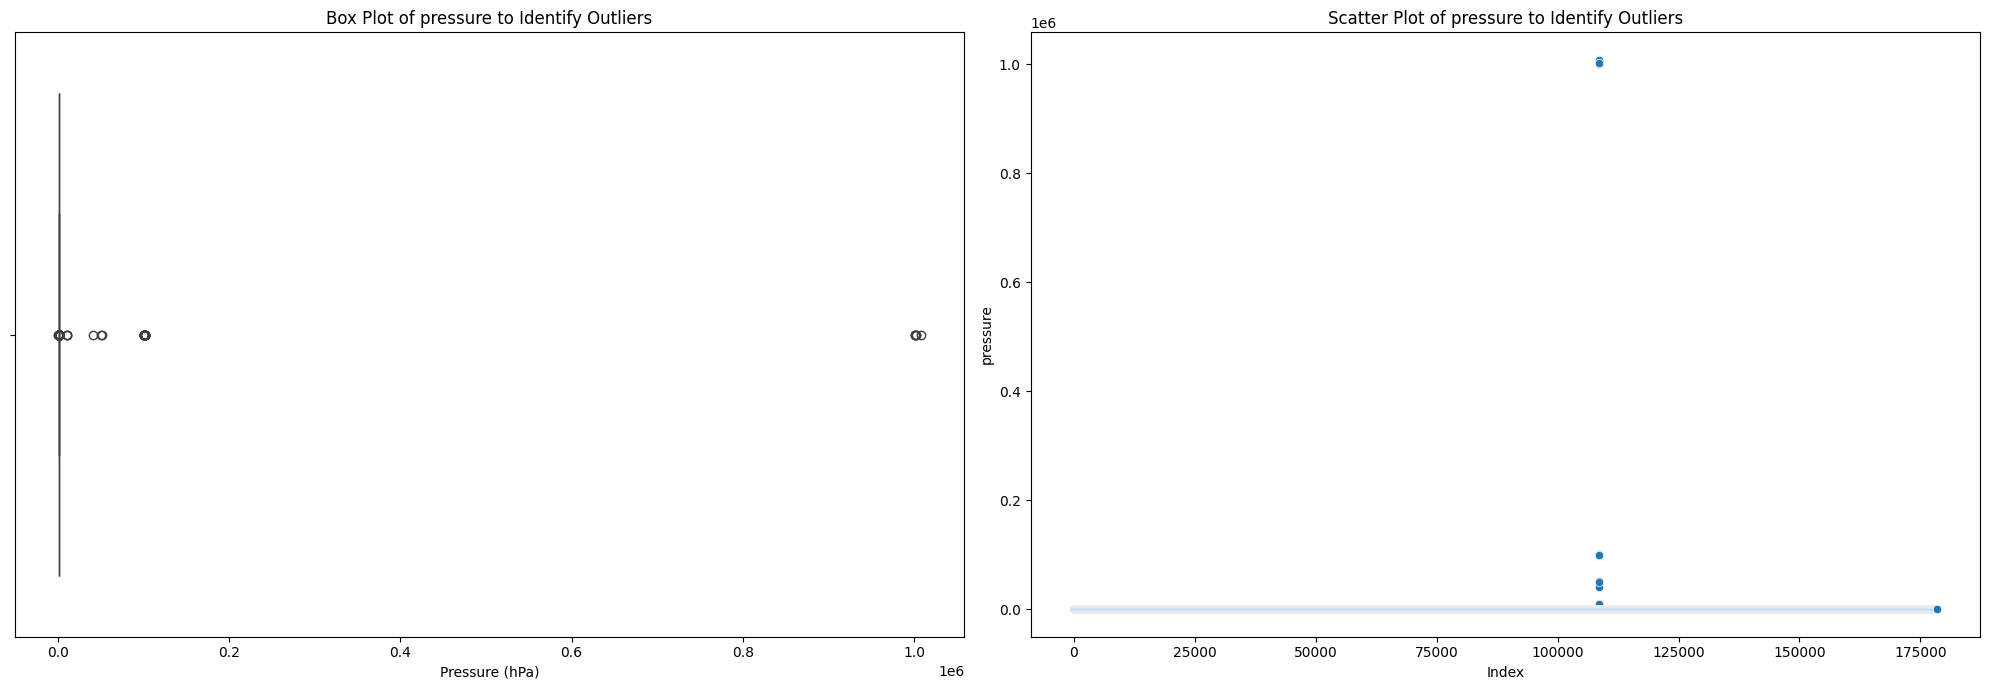

In [10]:
# Check for outliers in 'pressure' column

box_and_scatter_plot(df_weather, 'pressure')

In [11]:
pressure_mask = df_weather.pressure > 800000
df_weather[pressure_mask]

,city_name,time,temp_Celsius,temp_min_Celsius,temp_max_Celsius,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
108589,Barcelona,2015-02-21 01:00:00+00:00,10.10,10.10,10.10,1008371,0,3,337,12.0,0.0,0.0,12,503,rain,very heavy rain,10n
108596,Barcelona,2015-02-21 08:00:00+00:00,10.90,10.90,10.90,1001781,0,9,292,0.0,0.0,0.0,92,804,clouds,overcast clouds,04d
108597,Barcelona,2015-02-21 09:00:00+00:00,10.90,10.90,10.90,1001501,0,2,337,0.0,0.0,0.0,92,804,clouds,overcast clouds,04d
108598,Barcelona,2015-02-21 10:00:00+00:00,1.50,1.50,1.50,1000951,0,2,337,0.3,0.0,0.0,92,500,rain,light rain,10d
108618,Barcelona,2015-02-22 06:00:00+00:00,6.72,6.72,6.72,1002241,0,0,0,0.0,0.0,0.0,0,800,clear,sky is clear,01n
108619,Barcelona,2015-02-22 07:00:00+00:00,8.60,8.60,8.60,1002881,0,1,22,0.0,0.0,0.0,0,800,clear,sky is clear,01d


In [12]:
# Range for the 'pressure' outliers

city_p = ' Barcelona'
var_p = 'pressure'
date1_p = '2015-02-15 01:00:00+00:00'
date2_p = '2015-02-28 01:00:00+00:00'

In [13]:
# visualize_outlier(df_weather, city_p, var_p, date1_p, date2_p)

In [14]:
# Replace outliers in 'pressure' with NaNs

df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
df_weather.loc[df_weather.pressure < 931, 'pressure'] = np.nan

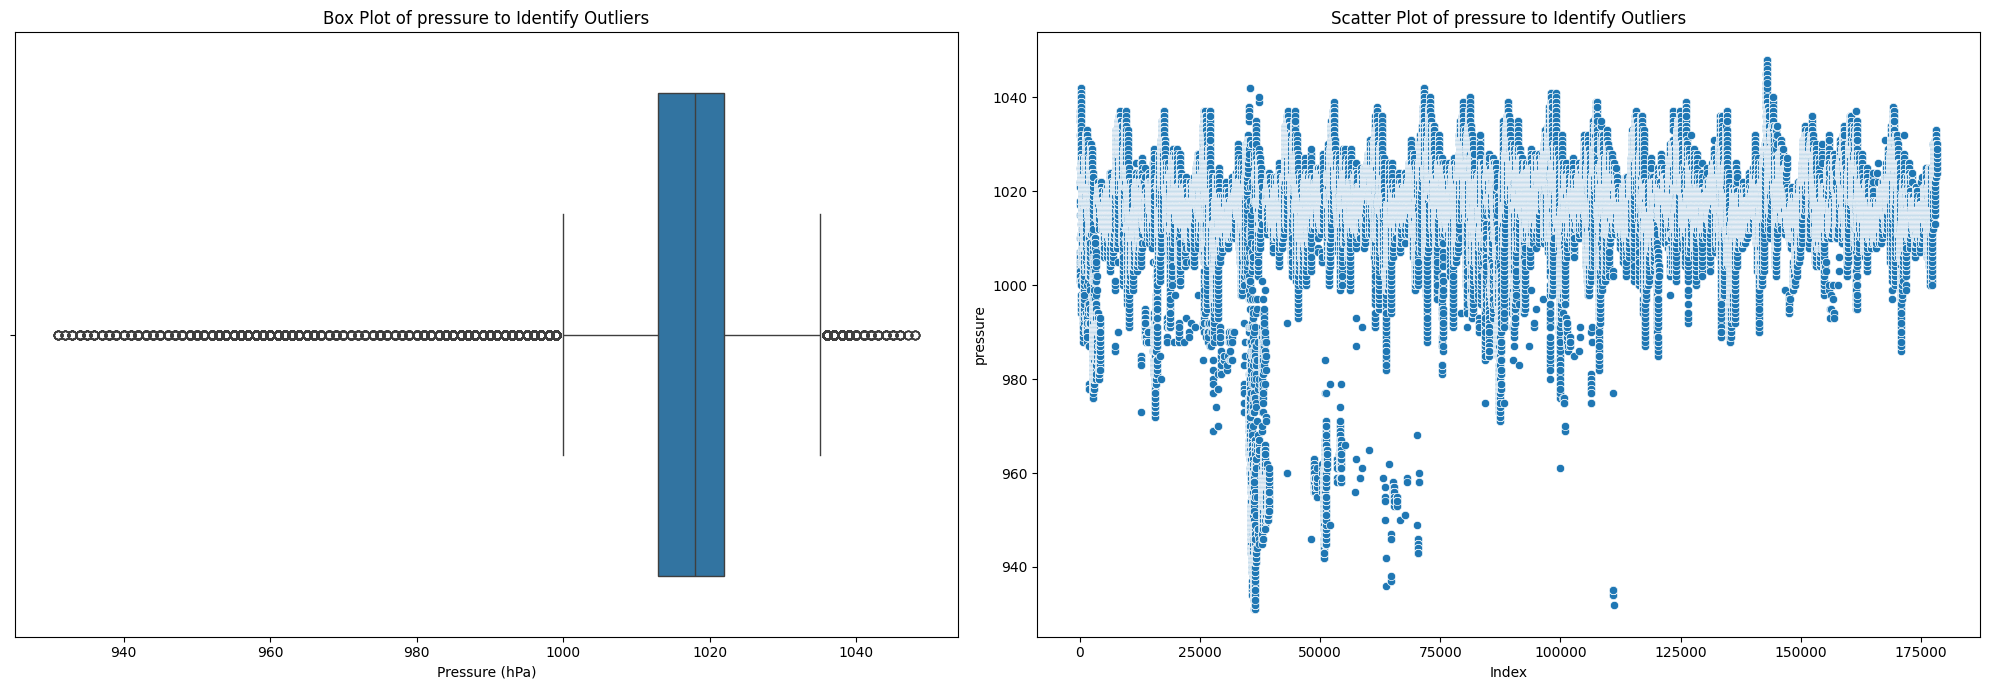

In [15]:
# Check again for outliers in 'pressure' column again

box_and_scatter_plot(df_weather, 'pressure')

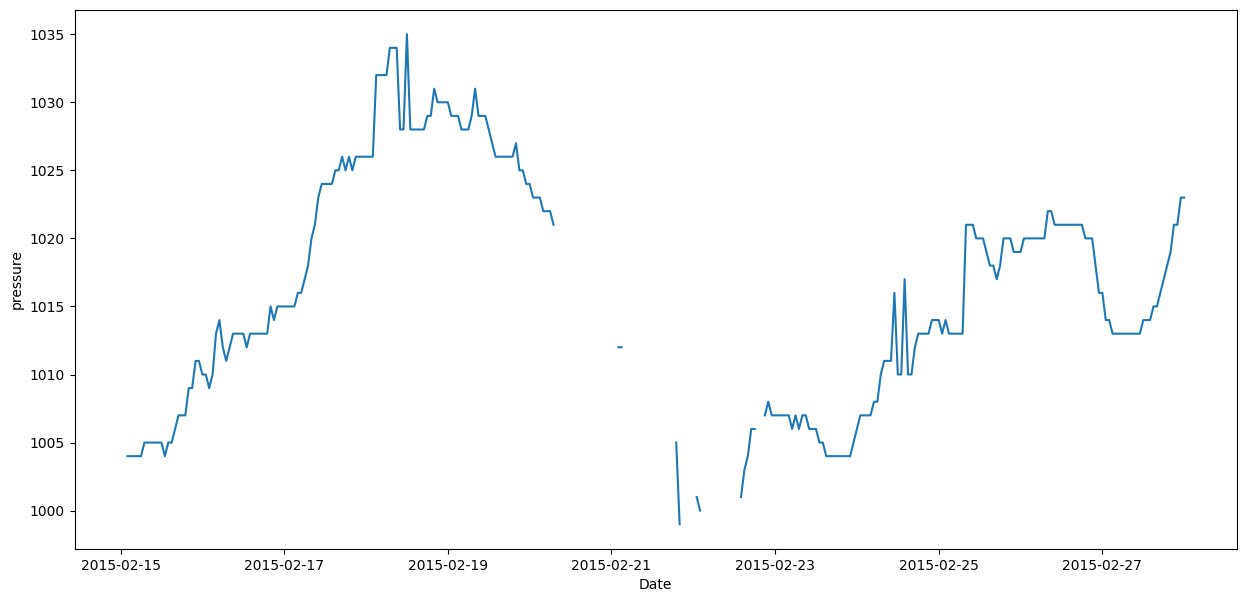

In [16]:
visualize_outlier(df_weather, city_p, var_p, date1_p, date2_p)

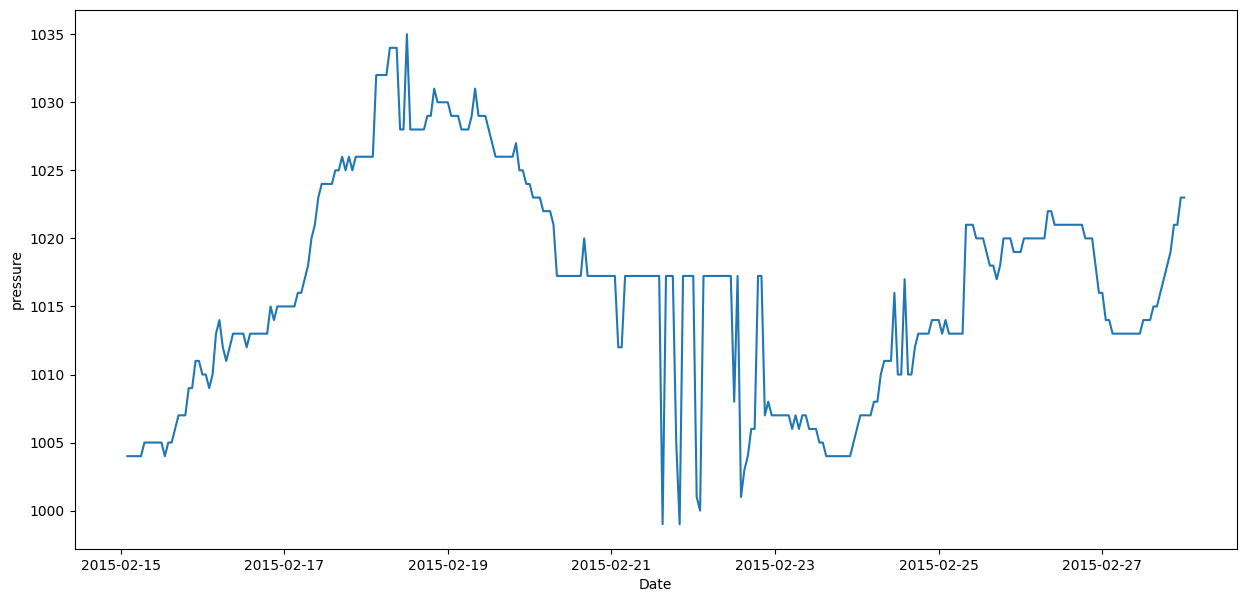

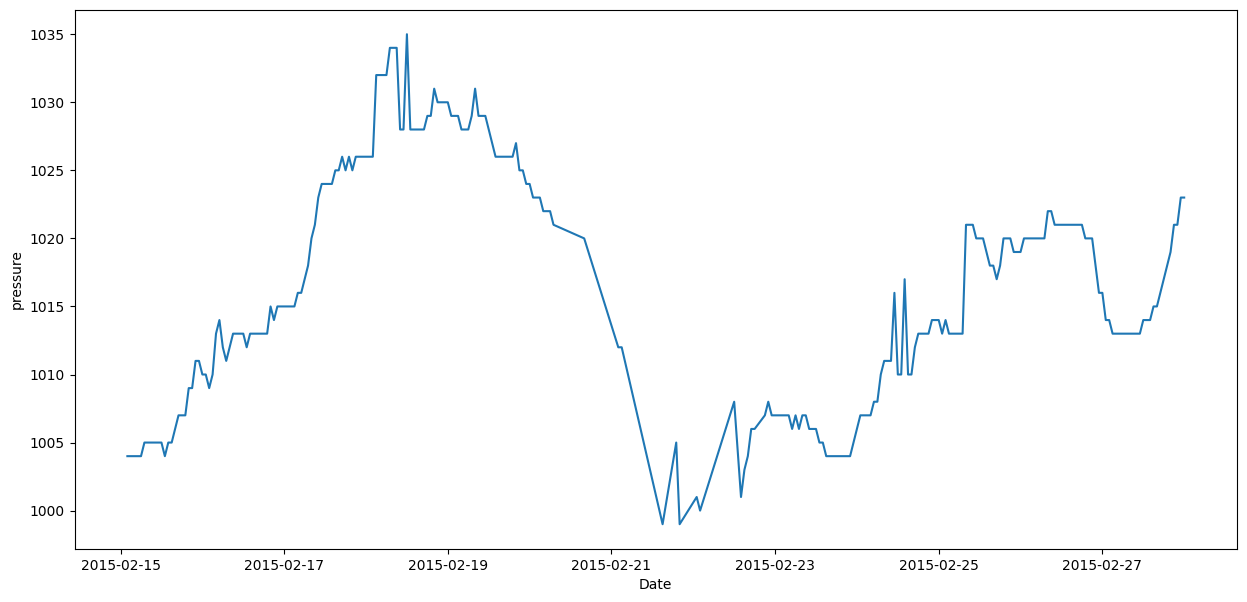

In [17]:
mean_pressure_Barcelona = df_weather[df_weather['city_name'] == ' Barcelona']['pressure'].mean()
df_weather_pressure_mean = df_weather.fillna(mean_pressure_Barcelona)

visualize_outlier(df_weather_pressure_mean, city_p, var_p, date1_p, date2_p)

df_weather3 = df_weather.copy()
df_weather3.interpolate(method = 'linear', limit_direction = 'forward', inplace = True, axis = 0)

visualize_outlier(df_weather3, city_p, var_p, date1_p, date2_p)

#### Wind_speed outliers

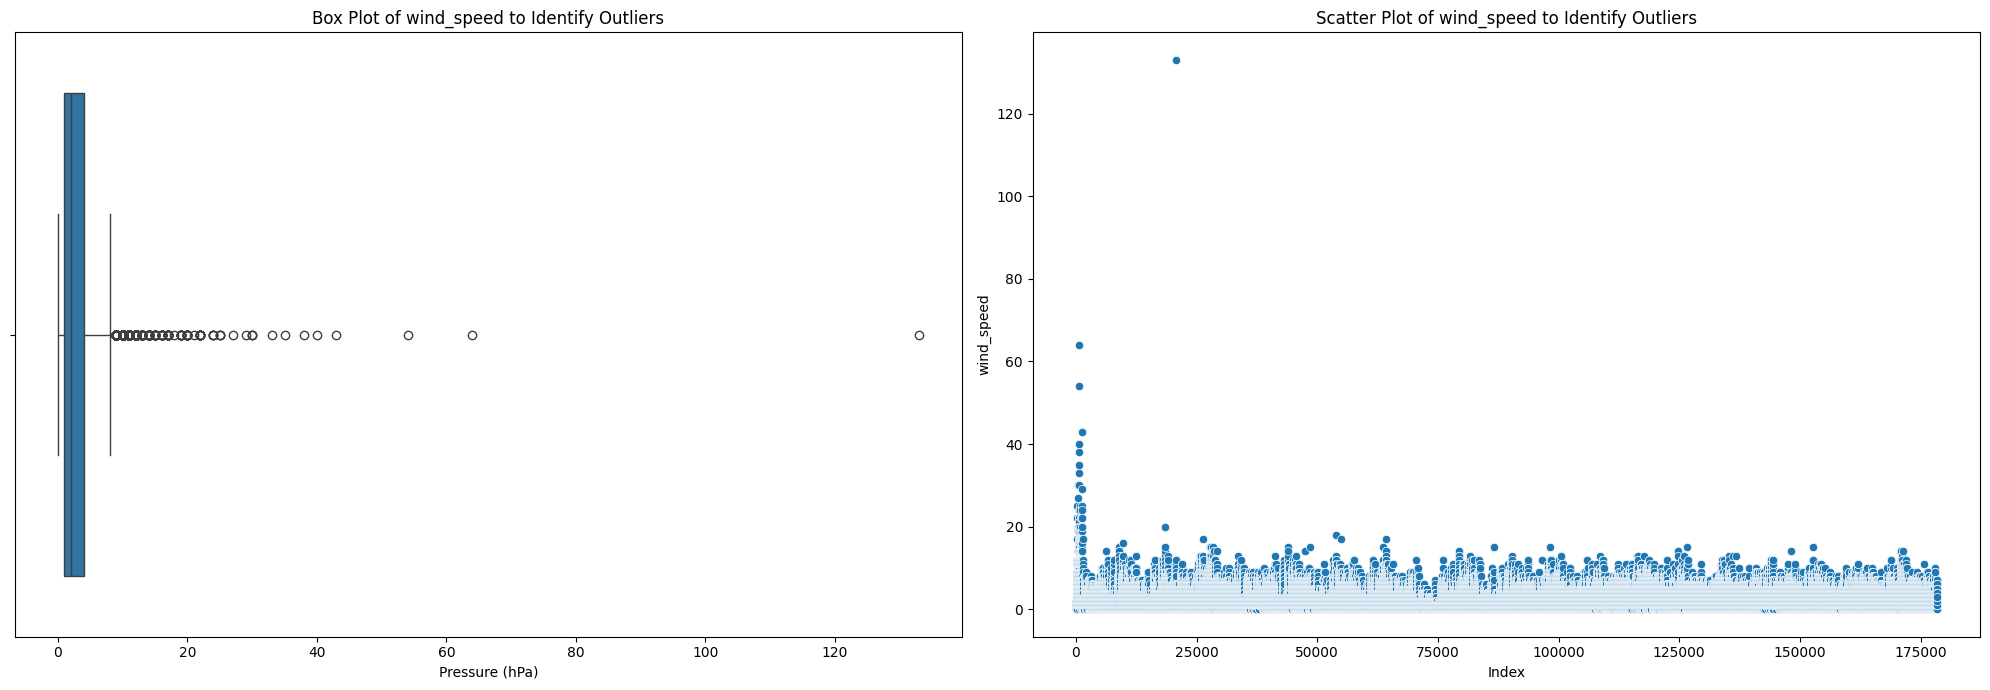

In [18]:
# Check for outliers in 'wind_speed' column

box_and_scatter_plot(df_weather, 'wind_speed')

In [19]:
wind_mask = df_weather.wind_speed > 50
df_weather[wind_mask]

,city_name,time,temp_Celsius,temp_min_Celsius,temp_max_Celsius,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
708,Valencia,2015-01-30 10:00:00+00:00,16.6,16.6,16.6,997.0,62,64,314,0.0,0.0,0.0,0,800,clear,sky is clear,01d
712,Valencia,2015-01-30 14:00:00+00:00,17.8,17.8,17.8,993.0,58,54,262,0.0,0.0,0.0,0,800,clear,sky is clear,01d
20725,Valencia,2017-05-11 10:00:00+00:00,20.0,20.0,20.0,1002.0,52,133,20,0.0,0.0,0.0,20,801,clouds,few clouds,02d


In [20]:
# Range for the 'wind_speed' outliers

city_w = 'Valencia'
var_w = 'wind_speed'
date1_w = '2015-01-29 10:00:00+00:00'
date2_w = '2015-01-31 10:00:00+00:00'
date3_w = '2017-05-10 10:00:00+00:00'
date4_w = '2017-05-12 10:00:00+00:00'

In [21]:
# Plot of the strange value in the wind_speed

# visualize_outlier(df_weather, city_w, var_w, date1_w, date2_w, date3_w, date4_w)

In [22]:
# Replace outliers in 'wind_speed' with NaNs

df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan

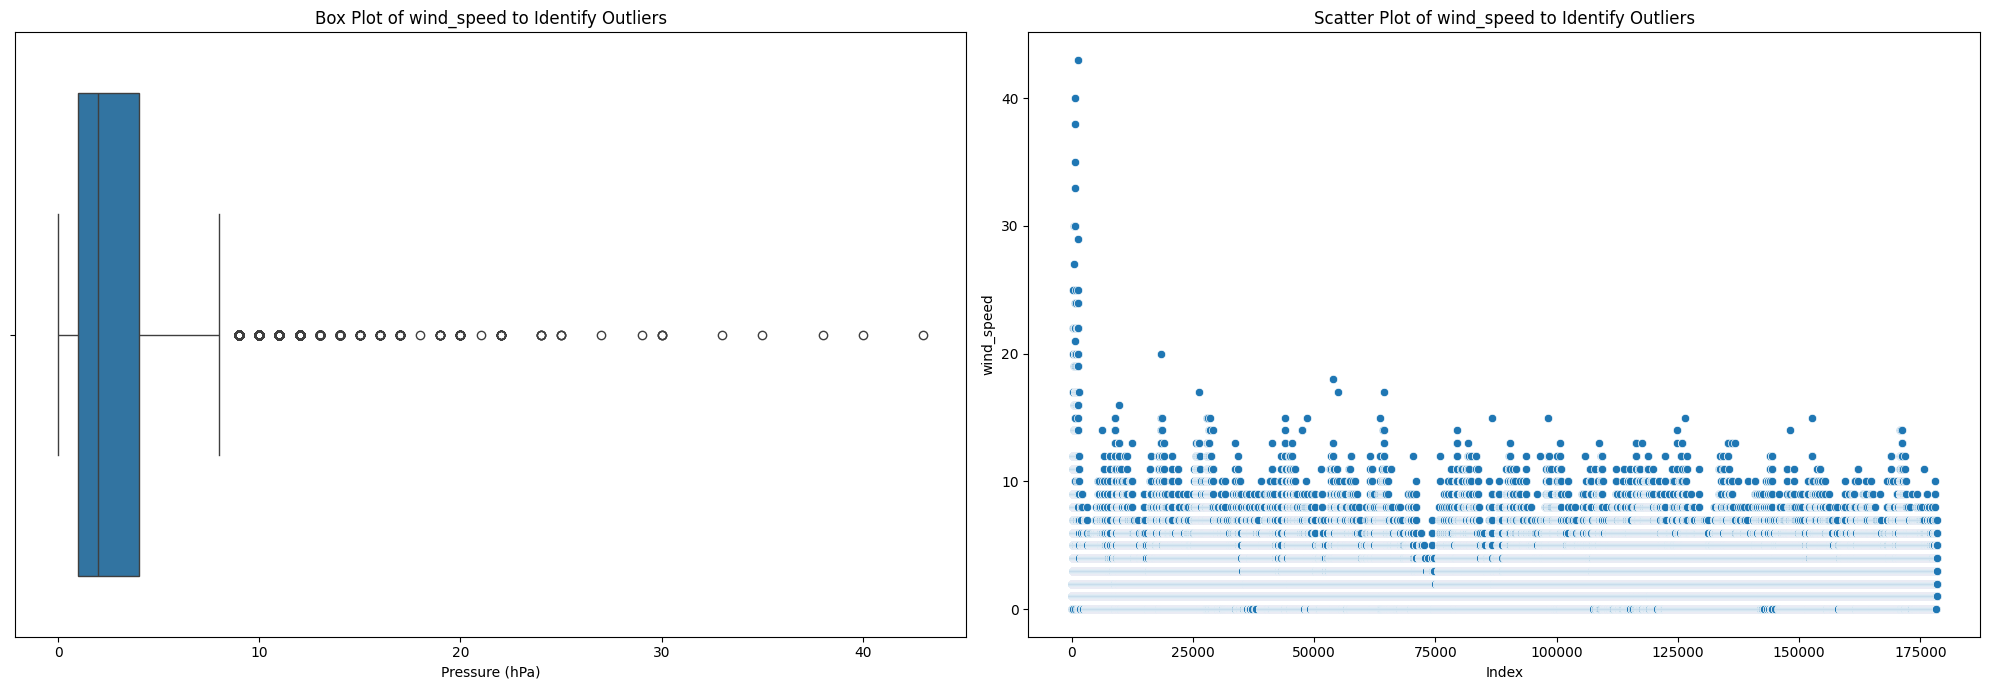

In [23]:
# Check for outliers in 'wind_speed' column again

box_and_scatter_plot(df_weather, 'wind_speed')

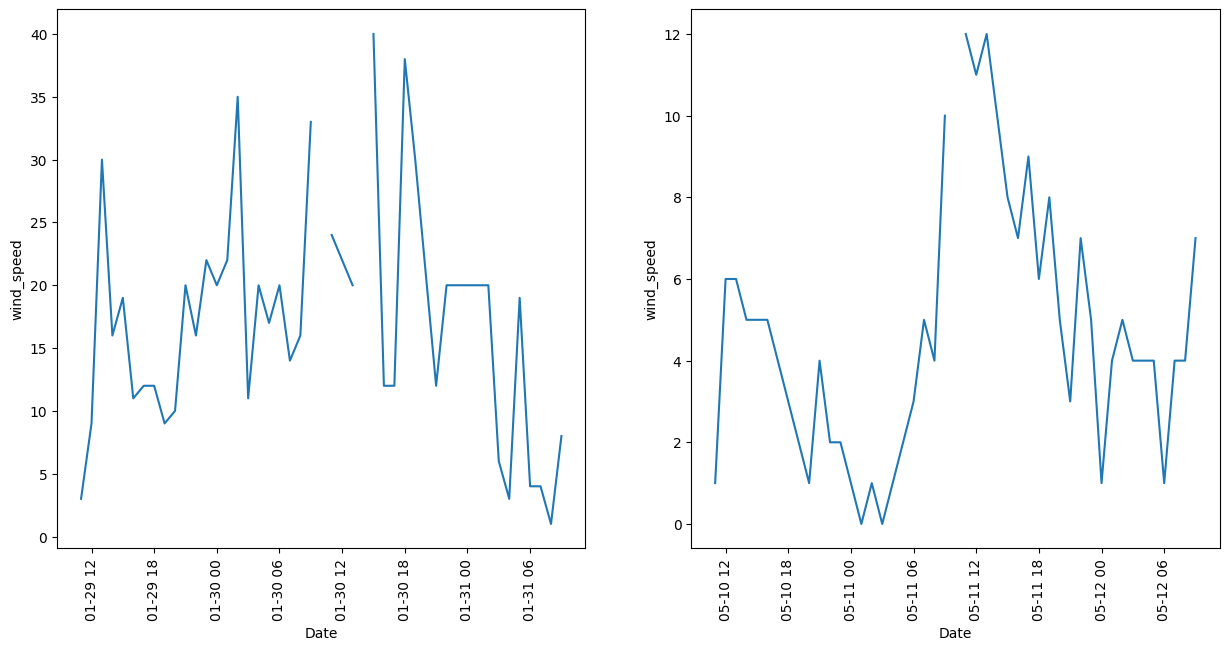

In [24]:
visualize_outlier(df_weather, city_w, var_w, date1_w, date2_w, date3_w, date4_w)

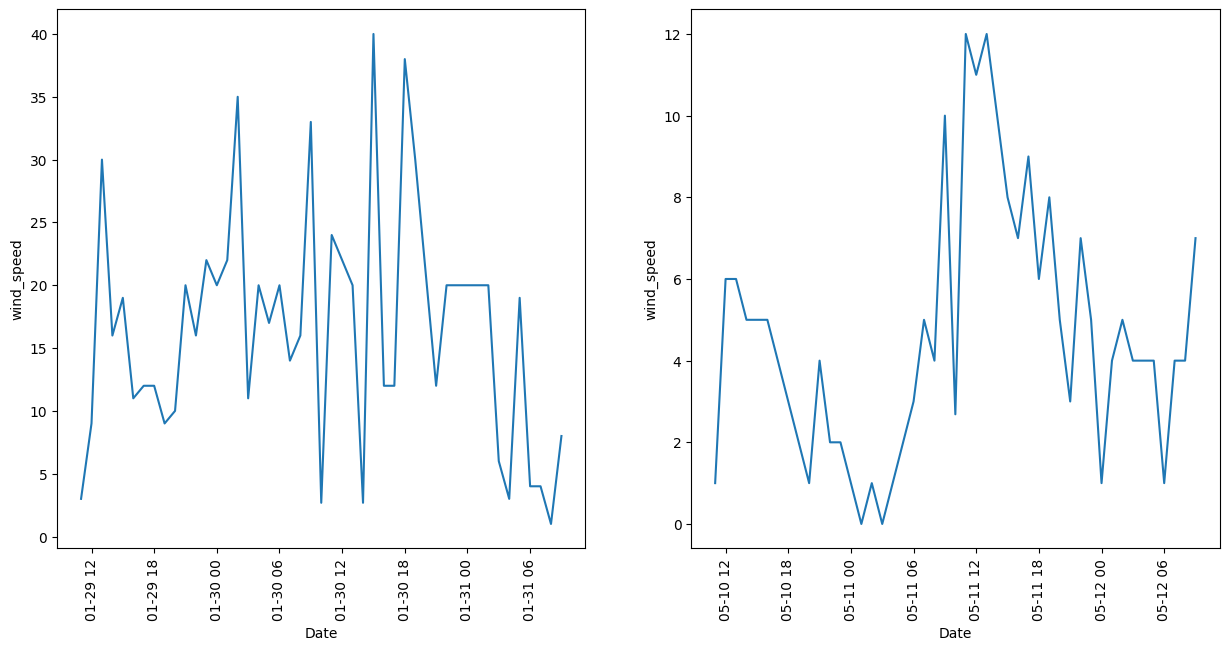

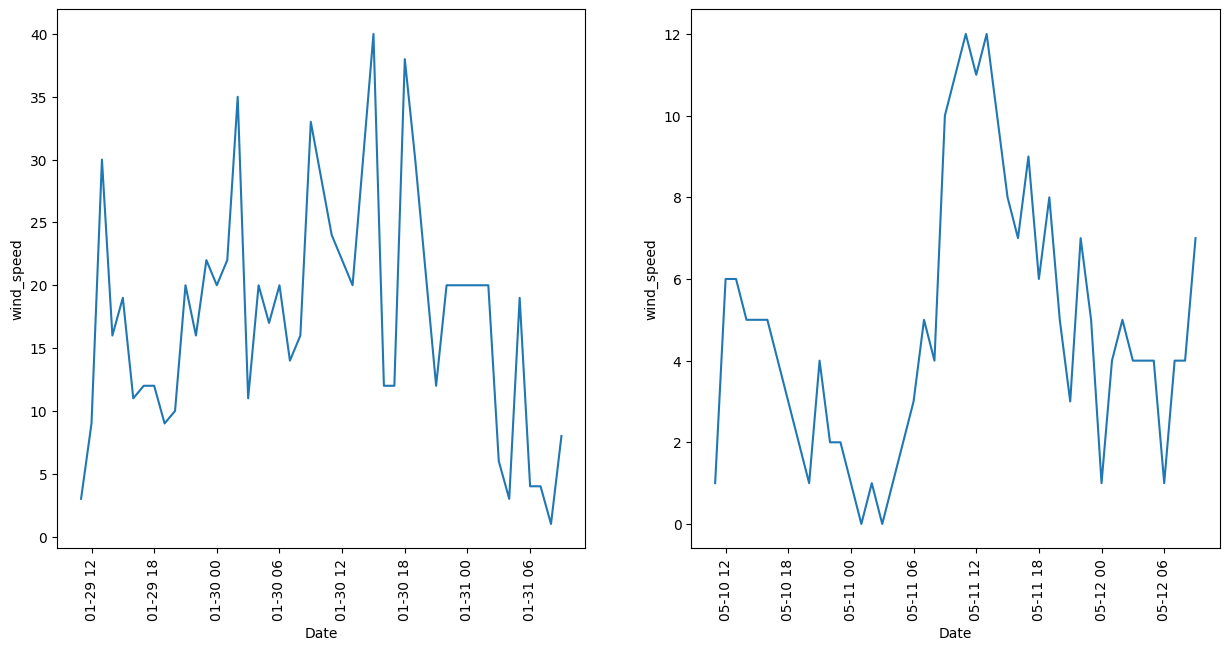

In [25]:
mean_wind_speed_Valencia = df_weather[df_weather['city_name'] == 'Valencia']['wind_speed'].mean()
df_weather_wind_mean = df_weather.fillna(mean_wind_speed_Valencia)

visualize_outlier(df_weather_wind_mean, city_w, var_w, date1_w, date2_w, date3_w, date4_w)

df_weather4 = df_weather.copy()
df_weather4.interpolate(method = 'linear', limit_direction = 'forward', inplace = True, axis = 0)

visualize_outlier(df_weather4, city_w, var_w, date1_w, date2_w, date3_w, date4_w)

In [26]:
df_weather.interpolate(method = 'linear', limit_direction = 'forward', inplace = True, axis = 0)

### Check the '3h_rain' columns

In [27]:
def plot_total(cities, df_column, check=False):
    if check == False:
        fig, axs = plt.subplots(1, len(cities), figsize=(5 * len(cities), 5), sharex=True)
        for i, city in enumerate(cities):
            city_data = df_weather[df_weather['city_name'] == city]
            axs[i].plot(city_data['time'], city_data[df_column])
            axs[i].set_title(f'{df_column} in {city}')
            axs[i].set_xlabel('Date')
            axs[i].set_ylabel('mm')
            axs[i].tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        fig, axs = plt.subplots(1, len(cities), figsize=(5 * len(cities), 7), sharex=False)
        for i, city in enumerate(cities):
            city_data = df_weather[df_weather['city_name'] == city]

            # Check if the previous 3 rows had values higher than 0
            condition = (city_data['rain_1h'].shift(1) > 0) & (city_data['rain_1h'].shift(2) > 0) & (city_data['rain_1h'].shift(3) > 0)

            result = city_data['rain_3h'][condition]
            
            # Plotting the result
            axs[i].plot(result.index, result.values, marker='o', linestyle='-', label='Rain 3h (Condition Met)')
            axs[i].set_title(f'{city}')
            axs[i].set_xlabel('Index')
            axs[i].set_ylabel('mm')
            axs[i].tick_params(axis='x', rotation=45)

            # Set x-axis range based on the result index
            if not result.empty:
                axs[i].set_xlim([result.index.min(), result.index.max()])

        fig.suptitle('Rain 3h Values Across Multiple Cities Where Previous 3 Rain 1h Values > 0', fontsize=16)
        plt.tight_layout()
        plt.show()

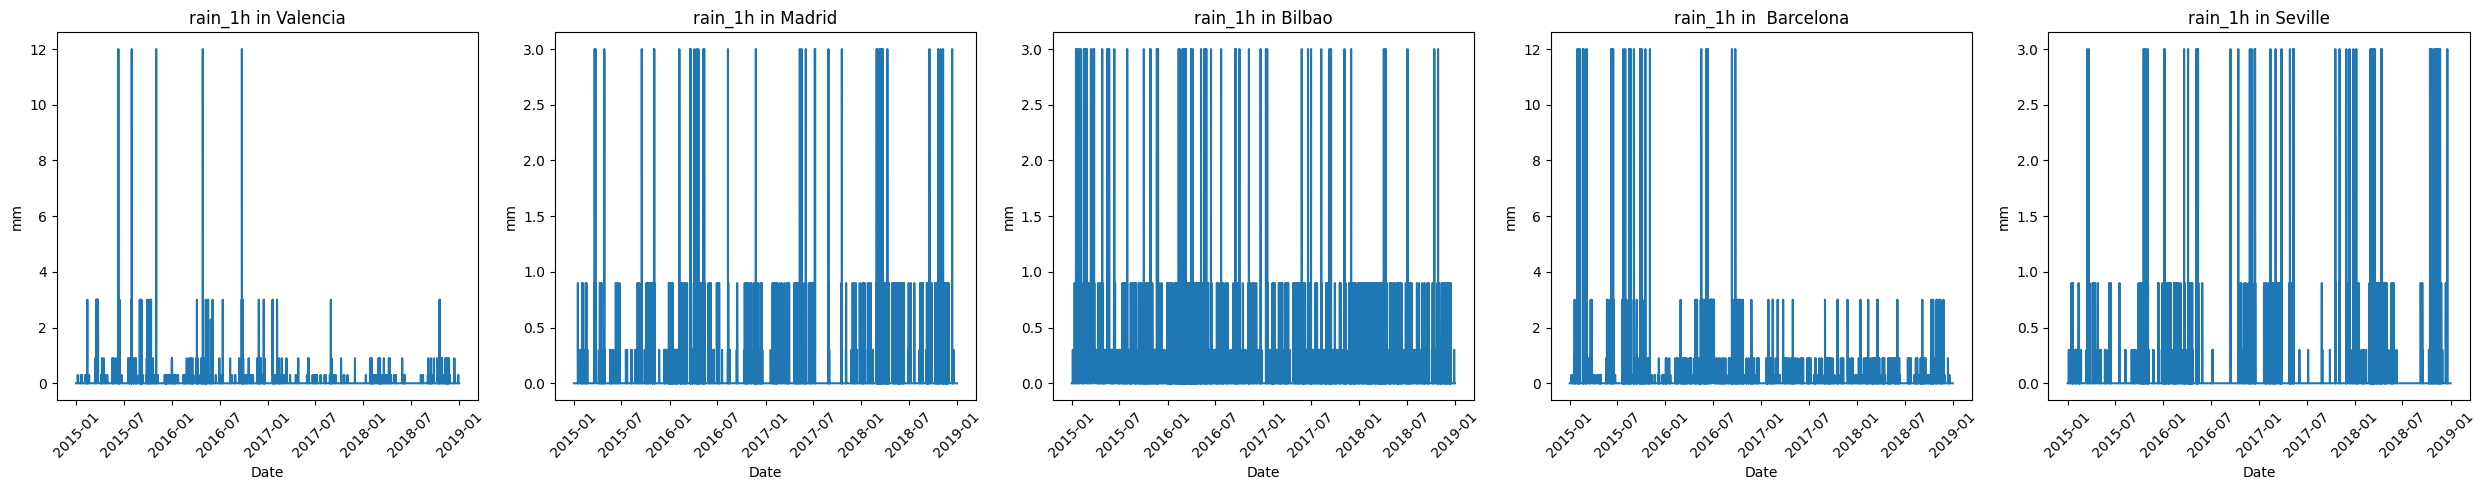

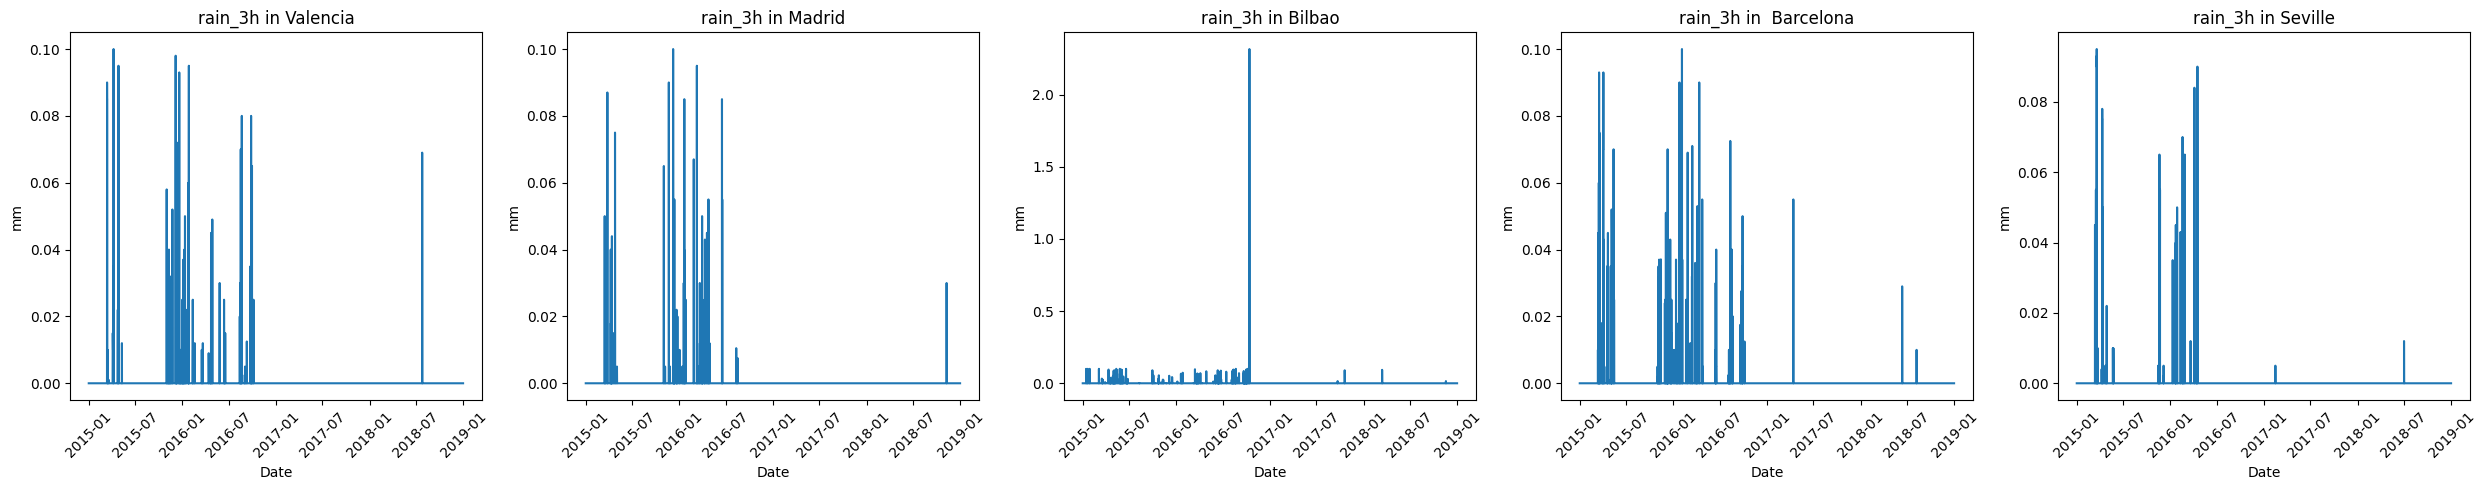

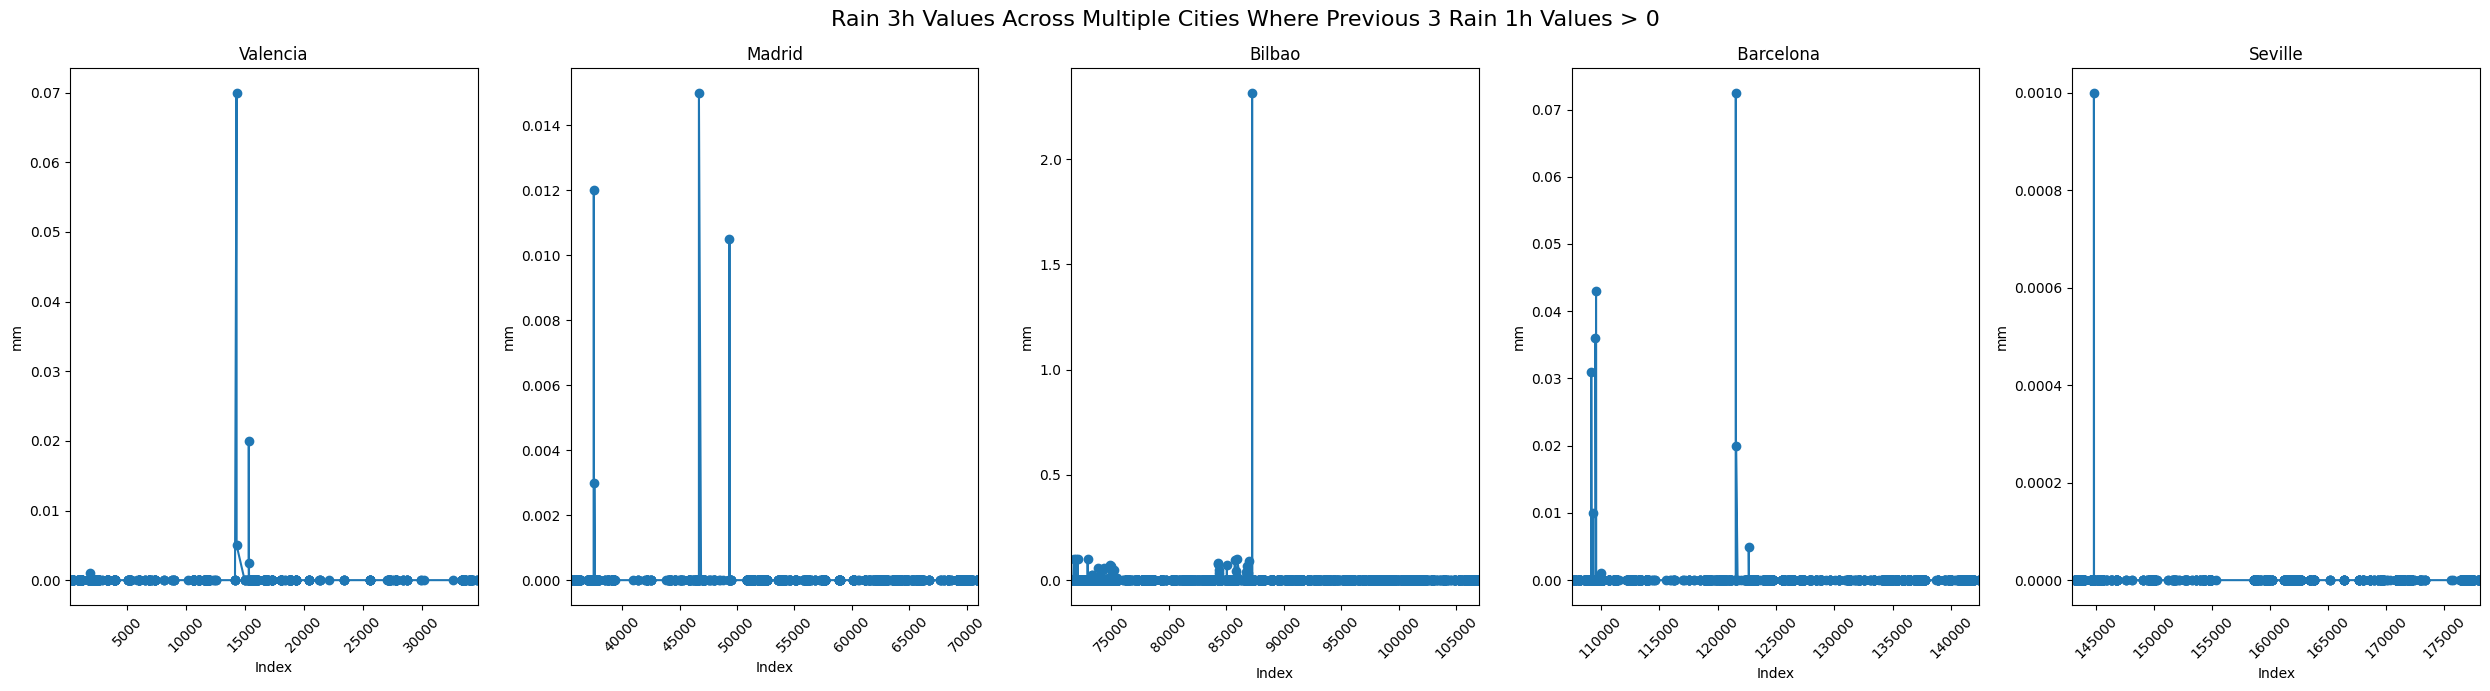

In [28]:
city_unique = df_weather['city_name'].unique()
plot_total(city_unique, 'rain_1h')
plot_total(city_unique, 'rain_3h')
plot_total(city_unique, 'rain_1h', check = True)

The third set of graphs shows `'rain_3h'` values only when the previous three `'rain_1h'` values were greater than 0. The few instances where this condition is met highlight the rarity and inconsistency of such events. This sparse distribution, along with occasional high peaks (e.g., in Bilbao), indicates possible measurement errors or very rare occurrences. 

Overall, the data quality for `'rain_3h'` is poor, with many missing and scattered values. Its low correlation with other meteorological data (like `'rain_1h'`) suggests that `'rain_3h'` adds little predictive value and could introduce noise. Therefore, removing `'rain_3h'` from the dataset is a justified decision that will improve the model's performance and reliability.

In [29]:
df_weather.drop(columns = ['rain_3h'], inplace = True)

## Energy Dataset

In [30]:
df_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [31]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35045 non-null  float64            
 2   generation fossil brown coal/lignite         35046 non-null  float64            
 3   generation fossil coal-derived gas           35046 non-null  float64            
 4   generation fossil gas                        35046 non-null  float64            
 5   generation fossil hard coal                  35046 non-null  float64            
 6   generation fossil oil                        35045 non-null  float64            
 7   generation fossil oil shale                  35046 non-null  float64            
 8   generation fossil peat    

In [32]:
df_energy.describe().round(4)

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.0000,35046.0000,35046.0,35046.0000,35046.0000,35045.0000,35046.0,35046.0,35046.0,0.0,...,35045.0000,35046.0,35046.0000,35064.0000,0.0,35064.0000,35064.0000,35028.0000,35064.0000,35064.0000
mean,383.5135,448.0592,0.0,5622.7375,4256.0657,298.3198,0.0,0.0,0.0,NaN,...,269.4521,0.0,5464.4798,1439.0667,NaN,5471.2167,28712.1300,28696.9399,49.8743,57.8840
std,85.3539,354.5686,0.0,2201.8305,1961.6010,52.5207,0.0,0.0,0.0,NaN,...,50.1955,0.0,3213.6916,1677.7034,NaN,3176.3129,4594.1009,4574.9880,14.6189,14.2041
min,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,NaN,...,0.0000,0.0,0.0000,0.0000,NaN,237.0000,18105.0000,18041.0000,2.0600,9.3300
25%,333.0000,0.0000,0.0,4126.0000,2527.0000,263.0000,0.0,0.0,0.0,NaN,...,240.0000,0.0,2933.0000,69.0000,NaN,2979.0000,24793.7500,24807.7500,41.4900,49.3475
50%,367.0000,509.0000,0.0,4969.0000,4474.0000,300.0000,0.0,0.0,0.0,NaN,...,279.0000,0.0,4849.0000,576.0000,NaN,4855.0000,28906.0000,28901.0000,50.5200,58.0200
75%,433.0000,757.0000,0.0,6429.0000,5838.7500,330.0000,0.0,0.0,0.0,NaN,...,310.0000,0.0,7398.0000,2636.0000,NaN,7353.0000,32263.2500,32192.0000,60.5300,68.0100
max,592.0000,999.0000,0.0,20034.0000,8359.0000,449.0000,0.0,0.0,0.0,NaN,...,357.0000,0.0,17436.0000,5836.0000,NaN,17430.0000,41390.0000,41015.0000,101.9900,116.8000


In [33]:
df_energy.isnull().sum()

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

###  Cleaning dataset and handling null values

We decided to drop some column because there is no collected data in them and they are variables that we cannot fill by ourself because they must be collected with a "tool": 
1. generation hydro pumped storage aggregated 
2. forecast wind offshore eday ahead

In [34]:
df_energy = df_energy.drop(columns=['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead'])

In [35]:
df_energy.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind onshore day ahead', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual'],
      dtype='object')

#### Correlation

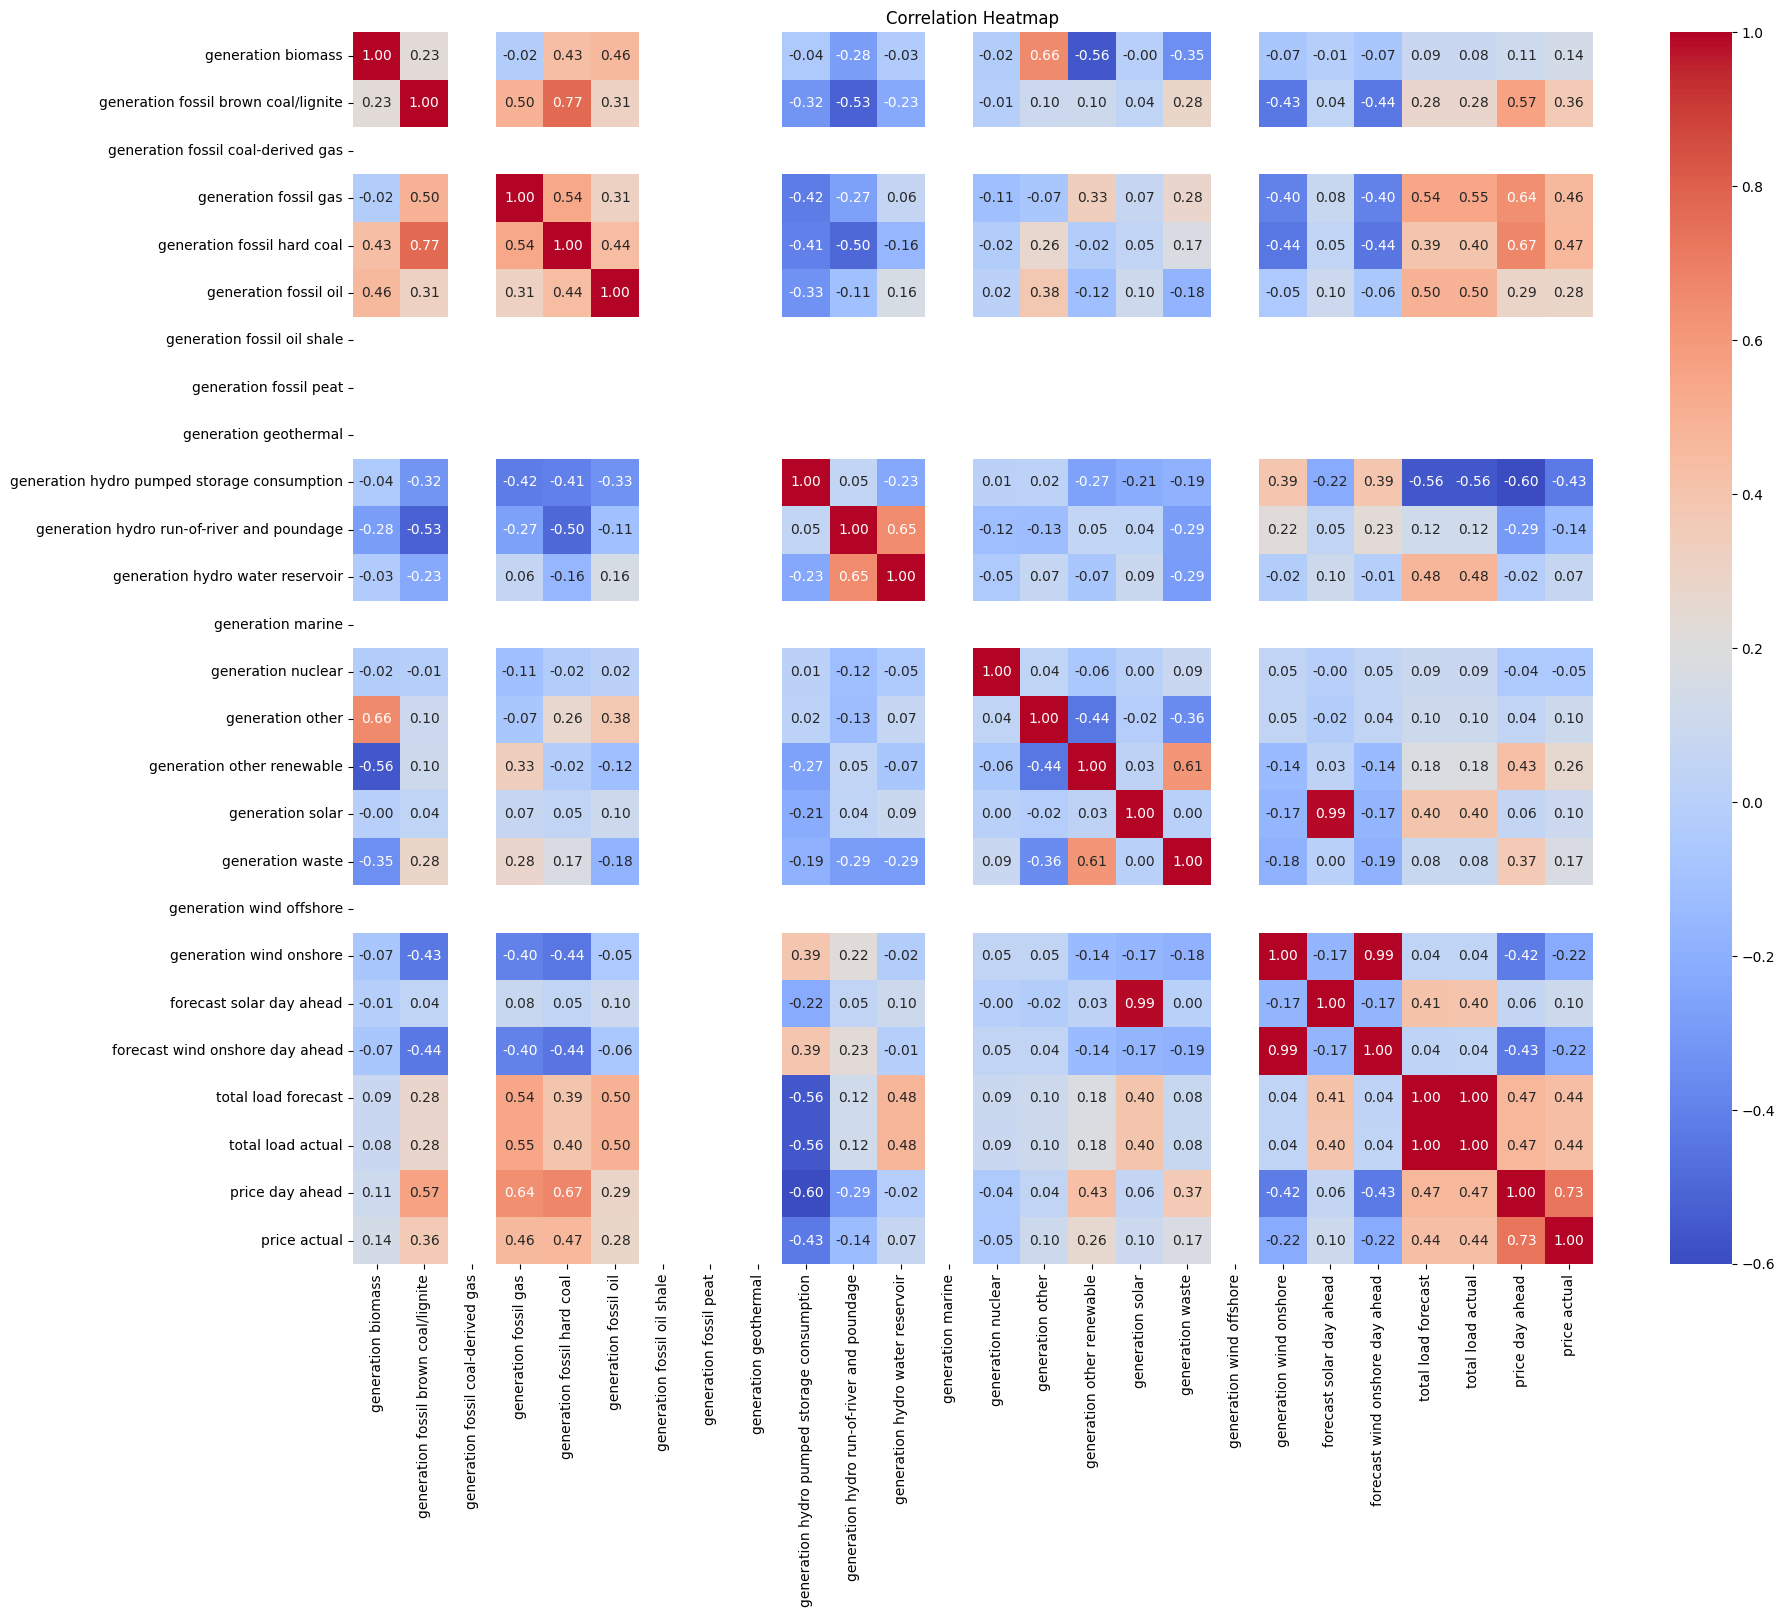

In [36]:
energy_corr = df_energy.drop(columns=['time'])
corr_energy = energy_corr.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_energy, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

We decided to drop features that have not correlation with any of other features, so they useless for our analysis.
1. 'generation fossil coal-derived gas'
2. 'generation fossil oil shale', 
3. 'generation fossil peat', 
4. 'generation geothermal', 
6. 'generation marine', 
7. 'generation wind offshore', 

We decided to drop features that have collinearity with other features, so they useless for our analysis: because collinearity will reduce the accuracy of the estimates.
- 'forecast wind onshore day ahead'
- 'forecast solar day ahead',
- 'total load forecast'

In [37]:
forecast_load_data = df_energy['total load forecast']
forecast_price_data = df_energy['price day ahead']
df_energy=df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 
                          'generation marine', 'generation wind offshore', 'total load forecast', 'forecast solar day ahead',
                          'forecast wind onshore day ahead'], axis=1)

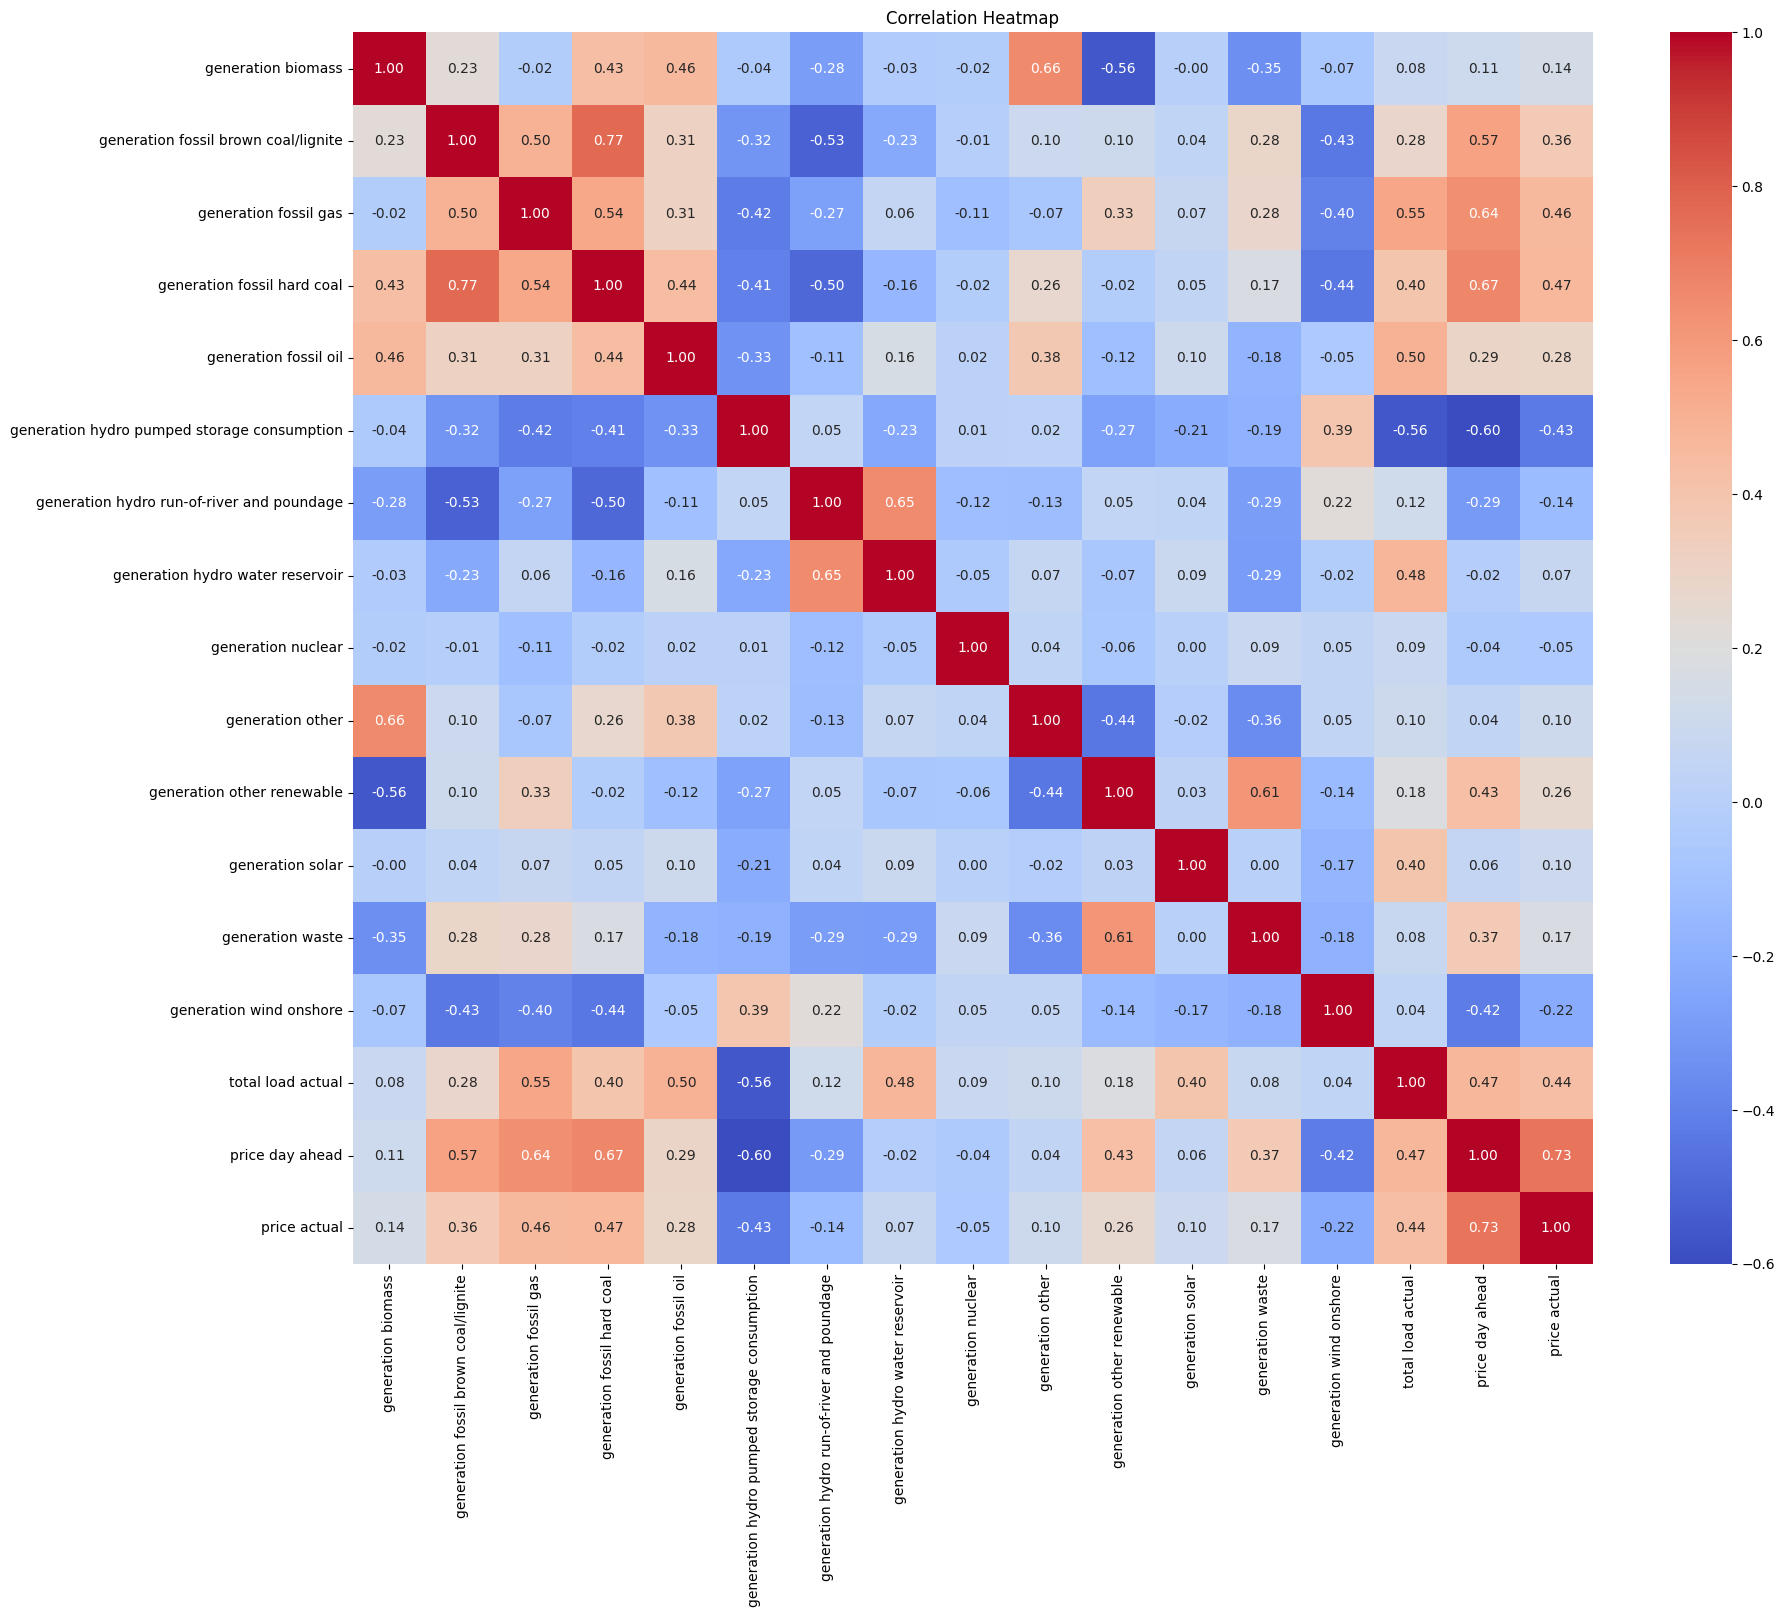

In [38]:
# The new correlation matrix

energy_corr = df_energy.drop(columns=['time'])
corr_energy = energy_corr.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_energy, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [39]:
print('There are {} missing values or NaNs in df_energy.'.format(df_energy.isnull().values.sum()))

temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'.format(temp_energy))

There are 292 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


In [40]:
df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

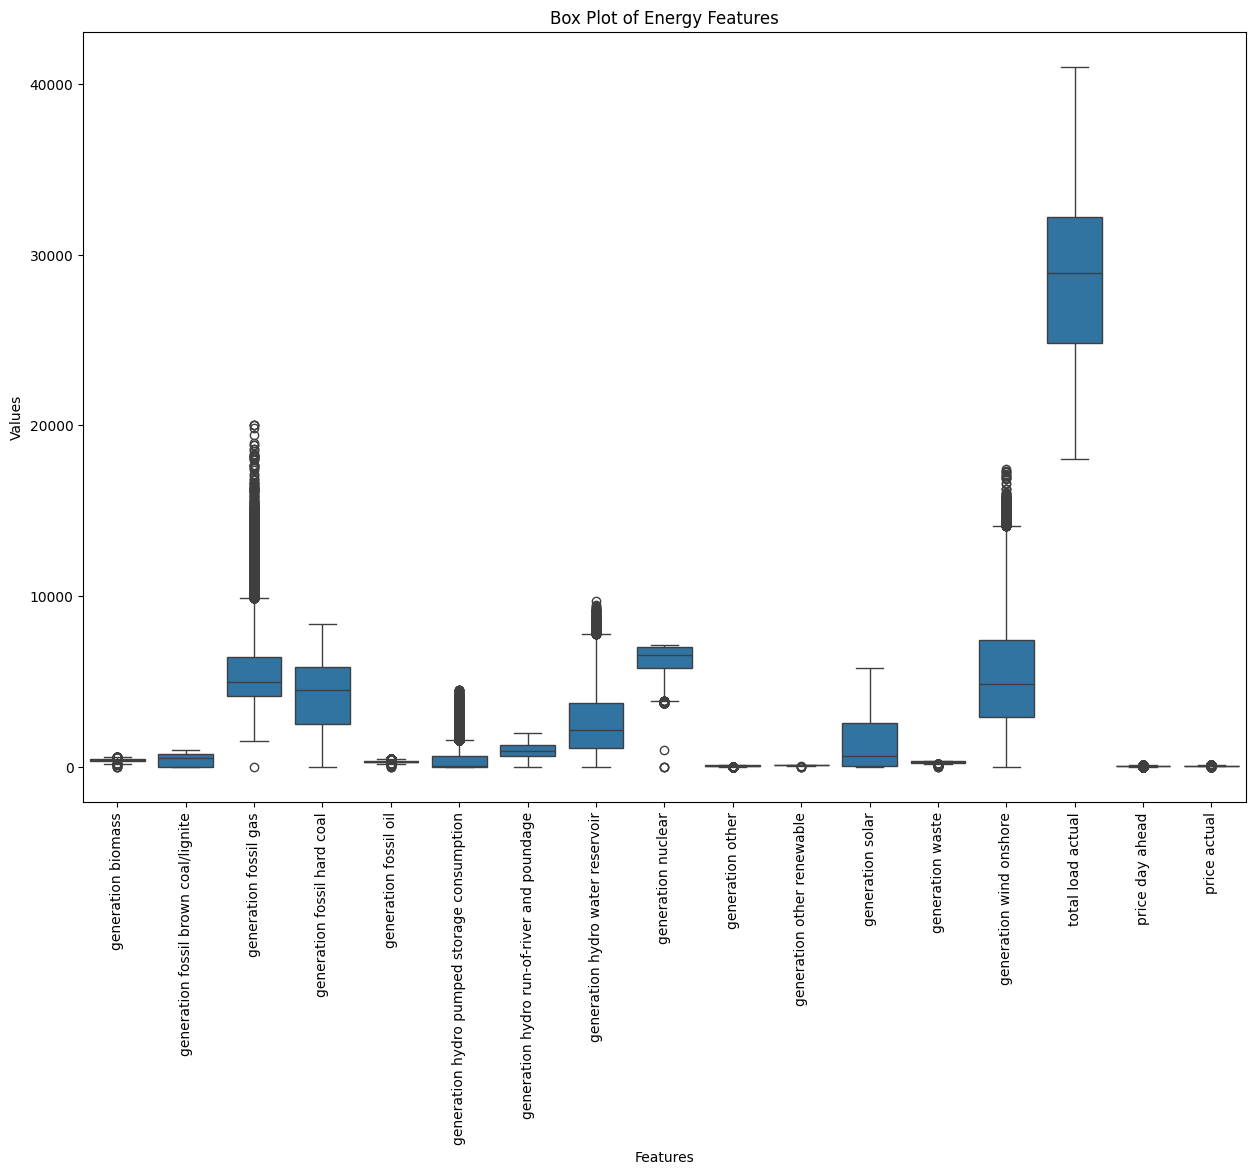

In [41]:
# List of columns to include in the boxplot
columns_to_plot = [
    'generation biomass', 
    'generation fossil brown coal/lignite', 
    'generation fossil gas',
    'generation fossil hard coal', 
    'generation fossil oil', 
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage', 
    'generation hydro water reservoir', 
    'generation nuclear',
    'generation other', 
    'generation other renewable', 
    'generation solar', 
    'generation waste',
    'generation wind onshore', 
    'total load actual', 
    'price day ahead', 
    'price actual'
]

# Melt the DataFrame
df_melted = df_energy.melt(value_vars = columns_to_plot, var_name = 'feature', value_name = 'value')

# Create the boxplot
plt.figure(figsize=(15, 10))
sns.boxplot(x='feature', y='value', data=df_melted)
plt.title('Box Plot of Energy Features')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

## Merged Dataset

### Duplicate rows

In [42]:
# Disply the number of rows for each city in df_weather dataset

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

city_unique = df_weather.city_name.unique()
grouped_weather = df_weather.groupby('city_name')

for city in city_unique:
    print('There are', format(grouped_weather.get_group('{}'.format(city)).shape[0]),'observations in df_weather about city:', city)

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia
There are 36267 observations in df_weather about city: Madrid
There are 35951 observations in df_weather about city: Bilbao
There are 35476 observations in df_weather about city:  Barcelona
There are 35557 observations in df_weather about city: Seville


In [43]:
# Create df_weather_2 and drop duplicate rows in df_weather and df_weather_2

df_weather2 = df_weather.drop_duplicates(subset=['time', 'city_name'], keep='last')

df_weather = df_weather.drop_duplicates(subset=['time', 'city_name'], keep='first')

In [44]:
# Display the number of rows for each city again

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

grouped_weather = df_weather.groupby('city_name')

for city in city_unique:
    print('There are', format(grouped_weather.get_group('{}'.format(city)).shape[0]),'observations in df_weather about city:', city)

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia
There are 35064 observations in df_weather about city: Madrid
There are 35064 observations in df_weather about city: Bilbao
There are 35064 observations in df_weather about city:  Barcelona
There are 35064 observations in df_weather about city: Seville


### Categorical features

We will drop the 'weather_icon' column as it is irrelevant to our analysis. Moreover, the 'weather_main' and 'weather_description' columns contain information similar to 'weather_id', providing qualitative descriptions of the weather at a specific hour. To select which one to use, we will:

- Examine the unique values in each column.

- Evaluate the consistency of their data.

In [45]:
weather_description_unique = df_weather.weather_description.unique()
weather_description_unique

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'proximity thunderstorm',
       'thunderstorm', 'light intensity shower rain',
       'light intensity drizzle', 'thunderstorm with rain', 'fog',
       'smoke', 'drizzle', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light snow', 'rain and snow',
       'light rain and snow', 'snow', 'sleet', 'rain and drizzle',
       'light intensity drizzle rain', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain', 'heavy snow',
       'sand dust whirls', 'proximity drizzle', 'dust',
       'light thunderstorm', 'squalls'], dtype=object)

In [46]:
weather_main_unique = df_weather.weather_main.unique()
weather_main_unique

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [47]:
weather_id_unique = df_weather.weather_id.unique()
weather_id_unique

array([800, 801, 802, 803, 804, 500, 501, 502, 701, 522, 521, 503, 202,
       200, 211, 520, 300, 201, 741, 711, 301, 302, 721, 600, 616, 615,
       601, 611, 311, 310, 620, 531, 602, 731, 761, 210, 771])

We can see that 'weather_main' offers the least detailed qualitative description compared to 'weather_id' and 'weather_description', which both provide more complex information and have a similar number of unique values.

Nonetheless, it's essential to assess the consistency of the data in each column. Since our dataset had duplicate rows and was cleaned using two different methods, a reliable way to check consistency is to compare the two cleaned dataframes, df_weather and df_weather_2. To accomplish this, we use the $R^2$ ("$R$-squared" or "coefficient of determination") metric, encoding 'weather_description' and 'weather_main' from strings to numerical labels.

**$R^2$**

$R^2$, also known as the coefficient of determination, is a statistical measure that represents the proportion of the variance of the dependent variable that is predictable by the independent variables. In simpler terms, it indicates how much the independent variables explain the variance of the dependent variable.

Values of $R^2$ range from 0 to 1:
- $R^2$ = 0: the independent variables explain nothing of the variability of the dependent variable.

- $R^2$ = 1: the independent variables explain all of the variability of the dependent variable.


The formula for $R^2$ is:

$$R^2 = 1 - \frac{RSS}{TSS}$$

Where:
1. **$RSS$** is the residual sum of squares (errors) $$RSS = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$
   Where:
   - $(y_i)$ is the actual value.

   - $(\hat{y}_i)$ is the expected value.


2. **$TSS$** is the total sum of squares $$TSS = \sum_{i=1}^{n} (y_i - \bar{y})^2$$
   Where:
   - $(y_i)$ is the actual value.
   
   - $(\bar{y})$ is the average of the actual values.

It is used to evaluate the goodness of fit of a regression model.

- **High $R^2$ value**: Indicates a good fit.
- **Low $R^2$ value**: Indicates a poor fit.

Encoding in the context of machine learning is the process of converting categorical data into numerical format so that the algorithms can process it. Most machine learning algorithms require numerical input and do not work well with categorical data.

Types of Encoding:

1. **Label Encoding**: This method converts categorical data into numerical data by assigning each unique category a numerical value.

2. **One-Hot Encoding**: This method converts categorical data into a set of binary columns, each representing a single category.

In [48]:
# Define a function which will calculate R-squared score for the same column in our two datasets

def encode_and_display_r2_score(dataset1, dataset2, column, categorical = False):
    datasets = [dataset1, dataset2]
    if categorical:
        for df in datasets:
            label_encoder = LabelEncoder()
            df.loc[:, column] = label_encoder.fit_transform(df[column])
    r2 = r2_score(dataset1[column], dataset2[column])
    print("R-Squared score of", column, "is", r2)

In [49]:
encode_and_display_r2_score(df_weather, df_weather2, 'weather_description', categorical = True)
encode_and_display_r2_score(df_weather, df_weather2, 'weather_main', categorical = True)
encode_and_display_r2_score(df_weather, df_weather2, 'weather_id')

R-Squared score of weather_description is 0.972978840026219
R-Squared score of weather_main is 0.9627152451498913
R-Squared score of weather_id is 0.9205784928822044


Based on the $R$-squared scores, it seems prudent to keep and encode either `'weather_description'` or `'weather_main'` once to maximize the information value of the dataset.

However, it is important to recognize that the $R^2$ values of these columns are not directly comparable because of the initial coding, but for the analysis we need to perform we can consider them compatible.

In [50]:
# Drop columns with qualitative weather information

df_weather = df_weather.drop(['weather_main', 'weather_id', 'weather_icon'], axis=1)

It is critical to note that the consistency checking method we used is not **completely accurate**. This is because it compares two dataframes in which duplicates have been cleaned using only two specific methods: keep the first rows and keep the last rows of duplicates. However, the method provides good results. 

In [51]:
# Split the df_weather into 5 dataframes (one for each city)

df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [52]:
# Merge all dataframes into the final dataframe

df_energy_weather = df_energy

for df in dfs:
    column_to_exclude = 'time'
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df_excluding_column = df.drop(columns=[column_to_exclude])
    df_with_suffix = df_excluding_column.add_suffix('_{}'.format(city_str))
    df_with_suffix[column_to_exclude] = df[column_to_exclude]
    df_energy_weather = df_energy_weather.merge(df_with_suffix, on = 'time')
    df_energy_weather = df_energy_weather.drop('city_name_{}'.format(city_str), axis=1)
    
df_energy_weather.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_Celsius_Barcelona',
       'temp_min_Celsius_Barcelona', 'temp_max_Celsius_Barcelona',
       'pressure_Barcelona', 'humidity_Barcelona', 'wind_speed_Barcelona',
       'wind_deg_Barcelona', 'rain_1h_Barcelona', 'snow_3h_Barcelona',
       'clouds_all_Barcelona', 'weather_description_Barcelona',
       'temp_Celsius_Bilbao', 'temp_min_Celsius_Bilbao',
       'temp_max_Celsius_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg

In [53]:
def extract_from_date(data, time_column):
    
    data["year"] = data[time_column].dt.year
    data["month"] = data[time_column].dt.month
    data["hour"] = data[time_column].dt.hour
    data["time"] = data[time_column].dt.time

    data['Day_Night'] = data['hour'].apply(determine_night_day)
    data['Season'] = data["month"].apply(determine_season)
    return data


def determine_night_day(hour):
    if 6 <= hour < 18:
        return 'Day'
    else:
        return 'Night'
    
def determine_season(month):
    seasons = {
        1: 'Winter', 2: 'Winter', 3: 'Spring',
        4: 'Spring', 5: 'Spring', 6: 'Summer',
        7: 'Summer', 8: 'Summer', 9: 'Fall',
        10: 'Fall', 11: 'Fall', 12: 'Winter'
    }
    return seasons[month]


df_energy_weather = extract_from_date(df_energy_weather, 'time')

In [54]:
def plot_actual_price1(price_col, other_col, df):
    
    mean_price = df[price_col].mean()
    
    df.groupby([other_col])[price_col].mean().plot.bar(figsize = (10,5), color = "cornflowerblue");
    
    plt.axhline(df[price_col].mean(), linestyle = '-', linewidth = 2, color = "red");

    plt.axhline(mean_price + df[price_col].std(), linestyle = ':', linewidth = 2, color = "red");

    plt.axhline(mean_price - df[price_col].std(), linestyle = ':', linewidth = 2,  color = "red");
    
    plt.title(f"{price_col} & {other_col}");
    plt.show()

In [ ]:
for col in ['year', 'month', 'hour', 'Day_Night', 'Season']:
    plot_actual_price1('price actual', col, df_energy_weather)

# **Requests**
1. Visualize the load (*the total electricity demand over time*) and marginal supply curves.
2. Can we forecast 24 hours in advance better than the TSO?
3. Can we predict electrical price by time of day better than TSO? 

## Request 1: Visualize the load (*the total electricity demand over time*) and marginal supply curves.

In [ ]:
# Plot total load actual over time
plt.figure(figsize=(14, 7))

# Calculate the 5-point moving average of 'total load actual'
df_energy['total load actual 5 MA'] = df_energy['total load actual'].rolling(window=24*7).mean()

plt.plot(df_energy['time'], df_energy['total load actual'], label='Total Load Actual')
plt.plot(df_energy['time'], df_energy['total load actual 5 MA'], label='5-Point Moving Average', linestyle='--')
#plt.plot(df_energy_weather['time'], df_energy_weather['total load forecast'], label='Total Load Actual')
plt.xlabel('Time')
plt.ylabel('Total Load (MW)')
plt.title('Load Curve')
plt.legend()
plt.show()

In [ ]:
# List of generation columns
generation_columns = ['generation biomass', 'generation fossil brown coal/lignite', 'generation fossil gas', 'generation fossil hard coal', 
                      'generation nuclear', 'generation solar', 'generation other']

# Define the time window
start_date = '2015-01-01'
end_date = '2015-01-7'

# Filter the dataframe for the specified time window
mask = (df_energy_weather['time'] >= start_date) & (df_energy_weather['time'] <= end_date)
filtered_df = df_energy_weather.loc[mask]

plt.figure(figsize=(20, 16))
filtered_df.plot(kind='area', x='time', y=generation_columns, stacked=True)
plt.xlabel('Time')
plt.ylabel('Generation (MW)')
plt.title('Marginal Supply Curve')
plt.legend(loc='upper left')
plt.show()

# **Models**

In [ ]:
# Define target columns
target_columns = ['total load actual', 'price actual']

# List of numerical columns to be normalized, excluding the target columns
numerical_cols = [col for col in df_energy_weather.select_dtypes(include=['float64', 'int64']).columns if col not in target_columns]

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the numerical features
df_energy_weather[numerical_cols] = scaler.fit_transform(df_energy_weather[numerical_cols])

# Check the normalized features
print(df_energy_weather.head())

## Building Model

The metrics of existing forecast for total load and price.

Here we had to make an critical assumption as in the dataset there is no info given on this topic.

The forecasted load and price data is not described clearly, it can be both the **forecast for the next 24 hours data** or it can be **forecasted value from 24 hours before**.

In our assumption we selected the case of forecasted value from 24 hours before and evaluated the forecasted values.

Below showed the TSO forecasts

In [ ]:
def evaluate_forecast(actual, predicted):
    """
    Evaluate the performance of the forecast using various metrics.
    
    Parameters:
    - actual: Series or array-like, actual values
    - predicted: Series or array-like, predicted values
    
    Returns:
    - A dictionary containing MSE, MAE, RMSE, and R² score.
    """
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    
    return {
        'Mean Squared Error': mse,
        'Mean Absolute Error': mae,
        'Root Mean Squared Error': rmse,
        'R² Score': r2
    }

# Example usage with the dataset
# Assuming df_final is your DataFrame and it includes columns 'total load actual', 'total load forecast', 'price actual', 'price day ahead'
actual_total_load = df_energy_weather['total load actual']

actual_price = df_energy_weather['price actual']

# Evaluate total load forecast
total_load_evaluation = evaluate_forecast(actual_total_load, forecast_load_data)
print("Total Load Forecast Evaluation:", total_load_evaluation)

# Evaluate price forecast
price_evaluation = evaluate_forecast(actual_price, forecast_price_data)
print("Price Forecast Evaluation:", price_evaluation)

## Model Evaluation

In [ ]:
def prepare_data(df, target, columns_to_exclude=[]):

    # Drop 'time' column if present
    if 'time' in df.columns:
        df = df.drop(columns=['time'])
    
    # Dynamically select features by excluding the columns we don't need
    features = [col for col in df.columns if col not in columns_to_exclude + [target]]
    
    X = df[features]
    y = df[target]
    
    return X, y

def train_model(X_train, y_train, model):
    
    model.fit(X_train, y_train)
    return model

def train_and_evaluate(df, target, model, columns_to_exclude=[]):

    X, y = prepare_data(df, target, columns_to_exclude)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model_train = train_model(X_train, y_train, model)
    
    evaluate_and_plot(X_test, y_test, model_train, target)

def evaluate_and_plot(X_test, y_test, model, target):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    MSE = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {MSE}')
    MAE = mean_absolute_error(y_test, y_pred)
    print(f'MAE score is: {MAE}')
    RMSE = np.sqrt(MSE)
    print(f'RMSE score is: {RMSE}')
    R2_Score = r2_score(y_test, y_pred)
    print(f'R2_Score score is: {R2_Score}')
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values[:100], label='Actual')
    plt.plot(y_pred[:100], label='Predicted')
    plt.xlabel('Sample')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted {target}')
    plt.legend()
    plt.show()

In [ ]:
# Shift the target columns by 24 hours to create new targets for forecasting 24 hours ahead
df_energy_weather['total_load_actual_24h_ahead'] = df_energy_weather['total load actual'].shift(-24)
df_energy_weather['price_actual_24h_ahead'] = df_energy_weather['price actual'].shift(-24)

# Drop rows with NaN values created by the shift
df_energy_weather = df_energy_weather.dropna(subset=['total_load_actual_24h_ahead', 'price_actual_24h_ahead'])


load_actual_24h_data = df_energy_weather['total_load_actual_24h_ahead'].values
price_actual_24h_data = df_energy_weather['price_actual_24h_ahead'].values

### Request 2: Can we forecast 24 hours in advance better than the TSO?

In [ ]:
target = 'total_load_actual_24h_ahead'
df_energy_weather.drop('price_actual_24h_ahead',axis=1,inplace=True)

#### Linear Regression

In [ ]:
model = LinearRegression()

# Run the pipeline
train_and_evaluate(df_energy_weather, target, model)

#### Polynomial

In [ ]:
def train_and_evaluate_polynomial(X, y, model):
    """
    Full pipeline: Split data, train model, and evaluate with plotting.
    
    Parameters:
    - X: DataFrame, features
    - y: Series, target
    - model: an instantiated machine learning model
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    trained_model = train_model(X_train, y_train, model)
    
    evaluate_and_plot(X_test, y_test, trained_model, target)

In [ ]:
# Define the target variable and columns to exclude
target = 'total_load_actual_24h_ahead'

# Prepare the data
X, y = prepare_data(df_energy_weather, target)

# Apply Polynomial Features transformation
degree = 2
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_polynomial = poly.fit_transform(X)

# Choose the model you want to use
model = LinearRegression()  # Example model

# Run the pipeline
train_and_evaluate_polynomial(X_polynomial, y, model)

RAM issues for polynomial of degree 3 

#### Gradient Boosting Regressor

In [ ]:
model = GradientBoostingRegressor(n_estimators = 100, random_state = 42)

# Run the pipeline
train_and_evaluate(df_energy_weather, target, model)

#### Random Forest Regressor

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
    
# Run the pipeline
train_and_evaluate(df_energy_weather, target, model)

### Request 2: Can we predict electrical price by time of day better than TSO? 

In [ ]:
# Define the target variable and columns to exclude
target = 'price_actual_24h_ahead'
df_energy_weather['price_actual_24h_ahead'] = price_actual_24h_data
df_energy_weather.drop('total_load_actual_24h_ahead',axis = 1,inplace = True)

#### Linear Regression

In [ ]:
model = LinearRegression()

# Run the pipeline
train_and_evaluate(df_energy_weather, target, model)

#### Polynomial

In [ ]:
# Define the target variable and columns to exclude
target = 'price_actual_24h_ahead'

# Prepare the data
X, y = prepare_data(df_1, target)

# Apply Polynomial Features transformation
degree = 2
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_polynomial = poly.fit_transform(X)

# Choose the model you want to use
model = LinearRegression()  # Example model

# Run the pipeline
train_and_evaluate_polynomial(X_polynomial, y, model)

#### Gradient Boosting Regressor

In [ ]:
model = GradientBoostingRegressor(n_estimators = 100, random_state = 42)
    
# Run the pipeline
train_and_evaluate(df_energy_weather, target, model)

# **Conclusions**

### Total Load Forecast Evaluation

| Measure               | Existing Load Forecast | Gradient Boosting Regressor | Multi Linear Regression | Polynomial Regression | Random Forest Regressor |
|-----------------------|------------------------|-----------------------------|-------------------------|-----------------------|--------------------------|
| Mean Squared Error    | 206707.53              | 7195124.53                  | 8816955.64              | 6937680.61            | 4302377.92               |
| Mean Absolute Error   | 316.89                 | 2025.67                     | 2273.01                 | 1994.16               | 1498.12                  |
| Root Mean Squared Error | 454.65               | 2682.37                     | 2969.34                 | 2633.95               | 2074.22                  |
| R² Score              | 0.9901                 | 0.6507                      | 0.5720                  | 0.6632                | 0.7911                   |

### Price Forecast Evaluation

| Measure               | Existing Price Forecast | Gradient Boosting Regressor | Multi Linear Regression | Polynomial Regression | Random Forest Regressor |
|-----------------------|-------------------------|-----------------------------|-------------------------|-----------------------|--------------------------|
| Mean Squared Error    | 175.56                  | 50.57                       | 57.05                   | 49.12                 | 30.92                    |
| Mean Absolute Error   | 10.49                   | 5.19                        | 5.49                    | 5.03                  | 3.96                     |
| Root Mean Squared Error | 13.25                 | 7.11                        | 7.55                    | 7.01                  | 5.56                     |
| R² Score              | 0.1298                  | 0.7398                      | 0.7065                  | 0.7473                | 0.8410                   |

### Summary:

- **Mean Squared Error (MSE)**: The average of the squares of the errors. Lower values indicate better performance.
- **Mean Absolute Error (MAE)**: The average of the absolute errors. Lower values indicate better performance.
- **Root Mean Squared Error (RMSE)**: The square root of the average of the squares of the errors. Lower values indicate better performance.
- **R² Score**: The proportion of the variance in the dependent variable that is predictable from the independent variables. Higher values (closer to 1) indicate better performance. Negative values can occur if the model is worse than a horizontal line (mean of the target values).

From the tables, it is evident that the Random Forest Regressor generally performs better across both total load and price forecasts. The performance differences highlight the importance of model selection and the potential need for feature scaling and transformation.